<a href="https://colab.research.google.com/github/christopher-reed/CA-High-Value-Crops/blob/master/Literature_Review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

http://calag.ucanr.edu/archive/?article=ca.v060n04p211
https://link.springer.com/content/pdf/10.1007/s10584-006-9141-3.pdf

# Lobell 2007

Historical effects of temperature and precipitation on California Crop Yields






*   Predict on state level
*   Fit technology trend using linear model and then consider the residuals the technology adjusted yields
*   Account for autocorrelation from alternate baring years using autoregressive models. 
  * Autoregressive model was fit to the time series of each crop. Number of previous years to consider was determined by AIC.
  * For most crops a zero order model was selected meaning that previous years yields did not have an impact
  * Nonzero order model for almonds, hay, and oranges. Used residuals from these in analysis. 
  * So used residuals from technology trend. Fit autoregressive model on those. Take those residuals which now have the impact of prevous years yields removed

* Climate data
  * 24 months. January of the year prior to harvest and December of the year of harvest

* Model
  * Seem to be fitting independent regressions on all of the data. Then using the model to predict residuals and calculate R2.
  * No mention of normalizing weather variables
  * Automated stepwise regression sometimes selected unrealsitic variables occuring after harvest. Therefore selected variables based on statistical relationships and knoledge of basic crop phenology
  * Assess the contribution of climate to yield trends the original untrended data was modeled as a function of both time and selected climate variables
  *Year coefficient was demed to represent the yield trend after the effects of the two climate varables were acounted for

* Results
  * Selected Feb tmin and Jan ppt as climate variables for almonds. Both have negative influence on almond yields as they each increase.





In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import sklearn
from sklearn import linear_model
from pandas.plotting import lag_plot

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
df_yield = pd.read_csv('/content/county_weather_yield.csv', index_col = 0)

#Almonds only
df_almonds = df_yield[df_yield['Crop Name'] == 'ALMONDS ALL']

df_almonds = df_almonds[~df_almonds['Yield per Acre'].isnull()]

In [60]:
df_yield.groupby('Crop Name').count()

,County,Year,January_ppt,January_tmax,January_tmin,January_tmean,January_vpdmax,January_vpdmin,February_ppt,February_tmax,February_tmin,February_tmean,February_vpdmax,February_vpdmin,March_ppt,March_tmax,March_tmin,March_tmean,March_vpdmax,March_vpdmin,April_ppt,April_tmax,April_tmin,April_tmean,April_vpdmax,April_vpdmin,May_ppt,May_tmax,May_tmin,May_tmean,May_vpdmax,May_vpdmin,June_ppt,June_tmax,June_tmin,June_tmean,June_vpdmax,June_vpdmin,July_ppt,July_tmax,...,July_vpdmax,July_vpdmin,August_ppt,August_tmax,August_tmin,August_tmean,August_vpdmax,August_vpdmin,September_ppt,September_tmax,September_tmin,September_tmean,September_vpdmax,September_vpdmin,October_ppt,October_tmax,October_tmin,October_tmean,October_vpdmax,October_vpdmin,November_ppt,November_tmax,November_tmin,November_tmean,November_vpdmax,November_vpdmin,December_ppt,December_tmax,December_tmin,December_tmean,December_vpdmax,December_vpdmin,Commodity Code,County Code,Harvested Acres,Yield per Acre,Production,Price per Unit,Unit,Total Value
Crop Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ALMONDS ALL,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,...,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,660,659,666,666,664,668
BERRIES STRAWBERRIES PROCESSING,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,...,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,139,46,46,136,136,134,136
GRAPES TABLE,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,...,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,282,282,282,282,281,282
GRAPES WINE,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,...,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1190,1158,1170,1170,1172,1203
LETTUCE HEAD,370,370,370,370,370,370,370,370,370,370,370,370,370,370,370,370,370,370,370,370,370,370,370,370,370,370,370,370,370,370,370,370,370,370,370,370,370,370,370,370,...,370,370,370,370,370,370,370,370,370,370,370,370,370,370,370,370,370,370,370,370,370,370,370,370,370,370,370,370,370,370,370,370,370,370,361,361,362,362,361,362
PISTACHIOS,366,366,366,366,366,366,366,366,366,366,366,366,366,366,366,366,366,366,366,366,366,366,366,366,366,366,366,366,366,366,366,366,366,366,366,366,366,366,366,366,...,366,366,366,366,366,366,366,366,366,366,366,366,366,366,366,366,366,366,366,366,366,366,366,366,366,366,366,366,366,366,366,366,366,366,334,334,334,334,333,334
TOMATOES PROCESSING,615,615,615,615,615,615,615,615,615,615,615,615,615,615,615,615,615,615,615,615,615,615,615,615,615,615,615,615,615,615,615,615,615,615,615,615,615,615,615,615,...,615,615,615,615,615,615,615,615,615,615,615,615,615,615,615,615,615,615,615,615,615,615,615,615,615,615,615,615,615,615,615,615,615,615,607,605,607,607,608,609
WALNUTS ENGLISH,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,...,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1176,1162,1161,1161,1161,1155,1162


**Visualization of total value of certain crops.**

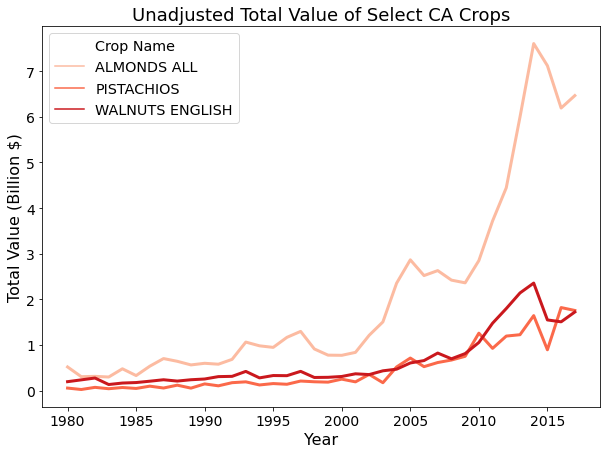

In [3]:
fig, ax = plt.subplots(figsize = (10,7))
df_value = df_yield[df_yield['Crop Name'].isin(['ALMONDS ALL', 'WALNUTS ENGLISH', 'PISTACHIOS'])]
df_value = df_value.groupby(['Crop Name', 'Year']).sum()[['Total Value']].reset_index()
ax = sns.lineplot(x = 'Year', y = 'Total Value', hue = 'Crop Name', linewidth = 3, data = df_value, palette = 'Reds')
ax.set_title('Unadjusted Total Value of Select CA Crops', fontsize = 18)
ax.set_ylabel('Total Value (Billion $)', fontsize = 16)
ax.set_yticklabels([0,0,1,2,3,4,5,6,7], size = 14)
ax.set_xlabel('Year', fontsize = 16)
ax.set_xticklabels([int(x) for x in ax.get_xticks()], size = 14)
plt.legend(fontsize='x-large', title_fontsize='40')

# Remove technology trend

In [0]:
#Predict yields using only years
target = df_almonds['Yield per Acre'].values
predictor = df_almonds['Year'].values
predictor_formatted = np.reshape(predictor, (len(predictor), 1))

#Fit model on entire dataset
model = linear_model.LinearRegression()
model.fit(predictor_formatted, target)

#Predict entire dataset from years
tech_trend = model.predict(predictor_formatted)

#Now consider residuals only
df_almonds['No Tech Yield per Acre'] = df_almonds['Yield per Acre'] - tech_trend

**How much variance does the year alone account for?**

In [5]:
np.corrcoef(target, model.predict(predictor_formatted))[0][1]**2

0.35390845188822945

**Compare trended and detrended yields.**

Text(0.5, 1.0, 'Detrended Yield per Acre')

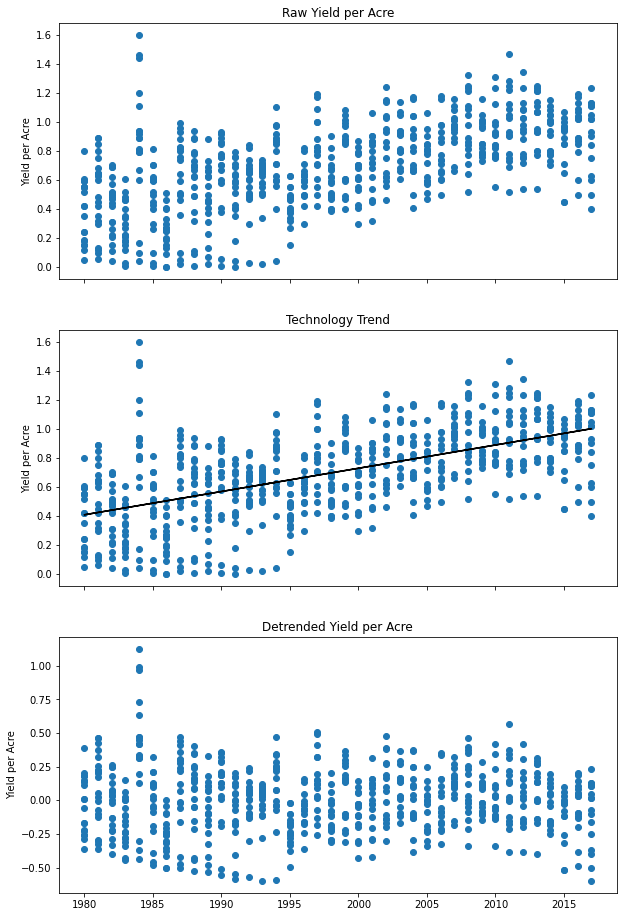

In [6]:
fig, ax = plt.subplots(3, sharex = True, sharey = False, figsize = (10,16))

plt.setp(ax, ylabel = 'Yield per Acre')

ax[0].scatter(df_almonds['Year'], df_almonds['Yield per Acre'])
ax[0].set_title('Raw Yield per Acre')

ax[1].scatter(df_almonds['Year'], df_almonds['Yield per Acre'])
ax[1].plot(df_almonds['Year'], tech_trend, color = 'black')
ax[1].set_title('Technology Trend')

ax[2].scatter(df_almonds['Year'], df_almonds['No Tech Yield per Acre'])
ax[2].set_title('Detrended Yield per Acre')

# Remove alternate bearing

**Fit AR model to yields to account of alternate yields.**

**Trouble is that we have different number of observations in each year so we need to find a way to make sure all have the same number of observations**

X(t+1) = b0 + b1*X(t-1) + b2*X(t-2)

**Is there evidence of alternate bearing?**

Text(0.5, 1.0, 'No Tech Yield per Acre')

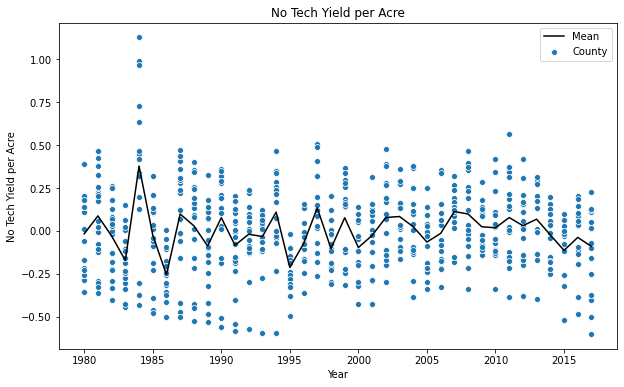

In [0]:
#Across all counties
fig, ax = plt.subplots(figsize = (10,6))
ax = sns.scatterplot(x = 'Year', y = 'No Tech Yield per Acre', data = df_almonds, label = 'County')
ax = sns.lineplot(x = 'Year', y = 'No Tech Yield per Acre', data = df_almonds, ci = None, color = 'Black', label = 'Mean')
ax.set_title('No Tech Yield per Acre')

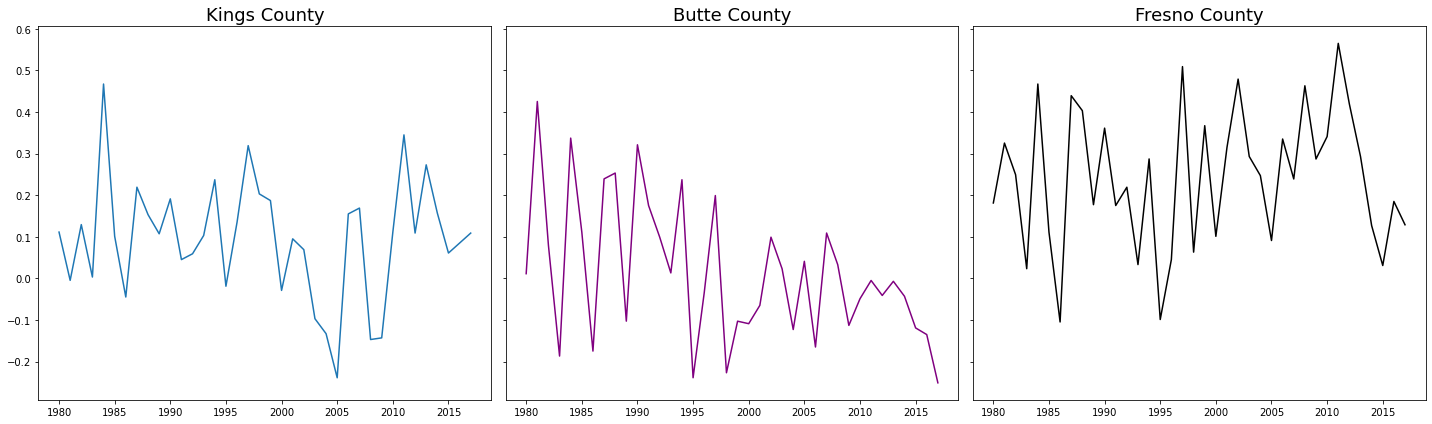

In [0]:
#Spot check a few counties

kings = df_almonds[df_almonds['County'] == 'Kings']
butte = df_almonds[df_almonds['County'] == 'Butte']
fresno = df_almonds[df_almonds['County'] == 'Fresno']

fig, ax = plt.subplots(1,3, sharex = False, sharey = True, figsize = (20,6))

ax[0].plot(kings['Year'], kings['No Tech Yield per Acre'])
ax[0].set_title('Kings County', fontsize = 18)

ax[1].plot(butte['Year'], butte['No Tech Yield per Acre'], color = 'purple')
ax[1].set_title('Butte County', fontsize = 18)

ax[2].plot(fresno['Year'], fresno['No Tech Yield per Acre'], color = 'black')
ax[2].set_title('Fresno County', fontsize = 18)

plt.tight_layout()

## Does the autocorrelation differ from one county to another?



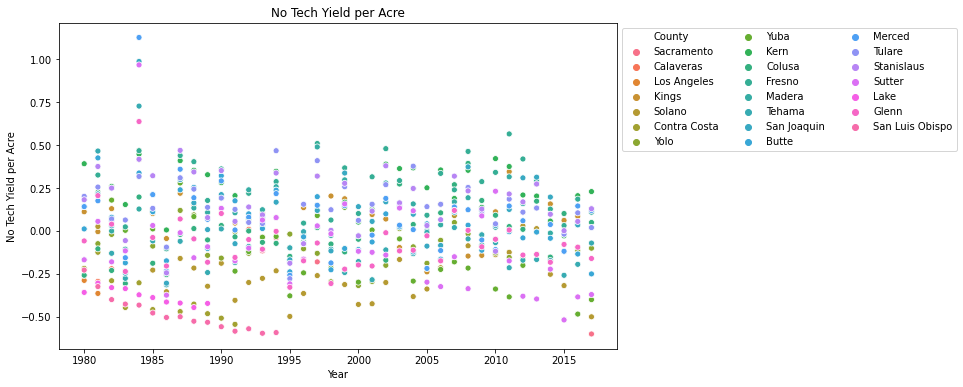

In [0]:
#Look at yield per acre trends for eahc county
fig, ax = plt.subplots(figsize = (10,6))
ax = sns.scatterplot(x = 'Year', y = 'No Tech Yield per Acre', hue = 'County', data = df_almonds)

ax.set_title('No Tech Yield per Acre')
plt.legend(ncol = 3, bbox_to_anchor = (1,1))

In [0]:
#Trouble counties that do not have complete records of 38 years
#Sacramento (1993 - 1998, 2017), Calaveras (1981 - 1993), Los Angeles (1980-1981), Contra Costa (continuous), Lake (continuous), SLO (continuos)
trouble_counties = ['Sacramento', 'Los Angeles'] 

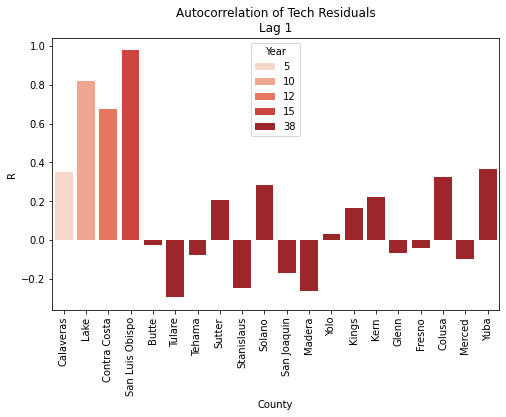

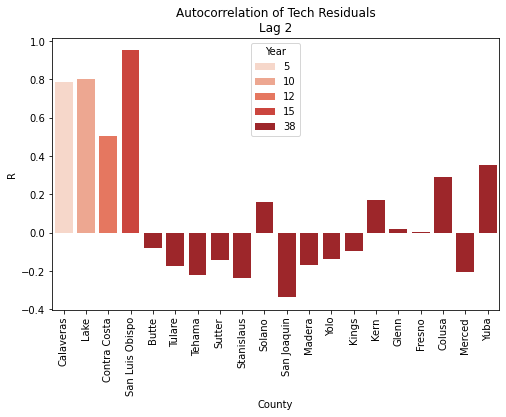

In [0]:
#Remove trouble counties
df_auto_corr = df_almonds[~df_almonds['County'].isin(trouble_counties)]

#Lag 1
df_auto_corr_1 = df_auto_corr.groupby('County')['No Tech Yield per Acre'].apply(pd.Series.autocorr, lag = 1).to_frame().reset_index()
num_obs_lag_1 = df_auto_corr.groupby('County').count()['Year'].reset_index()
df_auto_corr_1 = df_auto_corr_1.merge(num_obs_lag_1, on = 'County').sort_values(by = 'Year')

#Lag 2
df_auto_corr_2 = df_auto_corr.groupby('County')['No Tech Yield per Acre'].apply(pd.Series.autocorr, lag = 2).to_frame().reset_index()
num_obs_lag_2 = df_auto_corr.groupby('County').count()['Year'].reset_index()
df_auto_corr_2 = df_auto_corr_2.merge(num_obs_lag_1, on = 'County').sort_values(by = 'Year')

#Lag 1 plot
fig, ax = plt.subplots(figsize = (8,5))
ax = sns.barplot(x = 'County', y = 'No Tech Yield per Acre', data = df_auto_corr_1, hue = 'Year', palette = 'Reds', dodge = False)
ax.set_title('Autocorrelation of Tech Residuals\nLag 1')
ax.set_ylabel('R')
plt.xticks(rotation = 90)
plt.show()

fig, ax = plt.subplots(figsize = (8,5))
ax = sns.barplot(x = 'County', y = 'No Tech Yield per Acre', data = df_auto_corr_2, hue = 'Year', palette = 'Reds', dodge = False)
ax.set_title('Autocorrelation of Tech Residuals\nLag 2')
ax.set_ylabel('R')
plt.xticks(rotation = 90)
plt.show()

**It looks like the autocorrelation varies from county to county so it may be more appropriate to fit AR models for each county independently. Also it looks like the counties without a lot of observations have the strongest autocorrelation.**

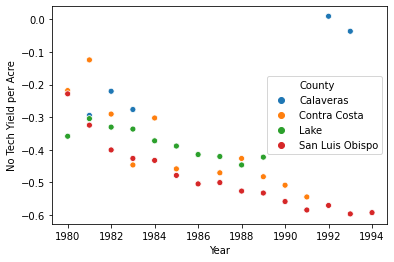

In [0]:
#Look at time series of high autocorrelation counties
county_inspect = ['Calaveras', 'Lake', 'Contra Costa', 'San Luis Obispo']

sns.scatterplot(x = 'Year', y = 'No Tech Yield per Acre', hue = 'County', data = df_almonds[df_almonds['County'].isin(county_inspect)])

**The autocorrelation is strong because all the counties have a linear trend.**

0.0011973323102304199


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

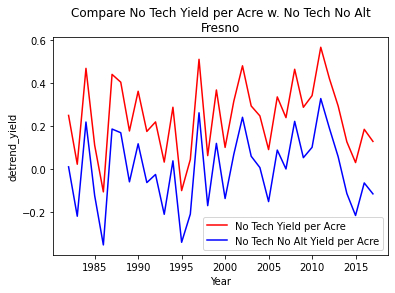

In [0]:
#Fresno AR test
df_fresno = df_almonds[df_almonds['County'] == 'Fresno']
df_fresno['lag_1'] = df_fresno['No Tech Yield per Acre'].shift(periods = 1)
df_fresno['lag_2'] = df_fresno['No Tech Yield per Acre'].shift(periods = 2)

df_fresno[['Year', 'No Tech Yield per Acre', 'lag_1', 'lag_2']]
#sns.scatterplot(x = 'No Tech Yield per Acre', y = 'lag_1', data = df_fresno)
#sns.lineplot(x = 'Year', y = 'No Tech Yield per Acre', data = df_fresno)

df_fresno_model = df_fresno[df_fresno['Year'] > 1981]

target = df_fresno_model['No Tech Yield per Acre'].values
predictor = df_fresno_model[['lag_1', 'lag_2']].values

model = linear_model.LinearRegression()
model.fit(predictor, target)

alternate_trend = model.predict(predictor)

#Look at R2
print(np.corrcoef(alternate_trend, df_fresno_model['No Tech Yield per Acre'])[0][1]**2)

df_fresno_model['Predictions'] = alternate_trend
df_fresno_model

#Residuals
df_fresno_model['detrend_yield'] = df_fresno_model['No Tech Yield per Acre'] - alternate_trend

fig, ax = plt.subplots()
ax = sns.lineplot(x = 'Year', y = 'No Tech Yield per Acre', data = df_fresno_model, color = 'Red', label = 'No Tech Yield per Acre')
ax = sns.lineplot(x = 'Year', y = 'detrend_yield', data = df_fresno_model, color = 'Blue', label = 'No Tech No Alt Yield per Acre')
ax.set_title('Compare No Tech Yield per Acre w. No Tech No Alt\nFresno')
plt.legend()

0.173553353580907


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

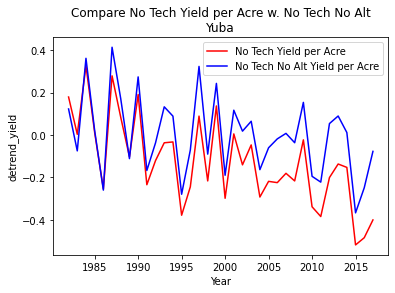

In [0]:
#Yuba AR Test
df_fresno = df_almonds[df_almonds['County'] == 'Yuba']
df_fresno['lag_1'] = df_fresno['No Tech Yield per Acre'].shift(periods = 1)
df_fresno['lag_2'] = df_fresno['No Tech Yield per Acre'].shift(periods = 2)

df_fresno[['Year', 'No Tech Yield per Acre', 'lag_1', 'lag_2']]
#sns.scatterplot(x = 'No Tech Yield per Acre', y = 'lag_1', data = df_fresno)
#sns.lineplot(x = 'Year', y = 'No Tech Yield per Acre', data = df_fresno)

df_fresno_model = df_fresno[df_fresno['Year'] > 1981]

target = df_fresno_model['No Tech Yield per Acre'].values
predictor = df_fresno_model[['lag_1', 'lag_2']].values

model = linear_model.LinearRegression()
model.fit(predictor, target)

alternate_trend = model.predict(predictor)

#Look at R2
print(np.corrcoef(alternate_trend, df_fresno_model['No Tech Yield per Acre'])[0][1]**2)

df_fresno_model['Predictions'] = alternate_trend
df_fresno_model

#Residuals
df_fresno_model['detrend_yield'] = df_fresno_model['No Tech Yield per Acre'] - alternate_trend

fig, ax = plt.subplots()
ax = sns.lineplot(x = 'Year', y = 'No Tech Yield per Acre', data = df_fresno_model, color = 'Red', label = 'No Tech Yield per Acre')
ax = sns.lineplot(x = 'Year', y = 'detrend_yield', data = df_fresno_model, color = 'Blue', label = 'No Tech No Alt Yield per Acre')
ax.set_title('Compare No Tech Yield per Acre w. No Tech No Alt\nYuba')
plt.legend()

## What happens if we assume autocorrelation is the same among all counties?

In [0]:
#Only select counties that have a complete set of 38 observations
df = df_almonds.groupby('County').count().reset_index()
counties = df.loc[df['Year'] == 38, 'County'].values

#Filtered to complete counties
df_almonds_c = df_almonds[df_almonds['County'].isin(counties)]

#Sort by year and county SO THE OBSERVATIONS STILL LINE UP
df_almonds_c = df_almonds_c.sort_values(by = ['Year', 'County'])

#Add two columns that have shifted tech adjusted yields
df_almonds_c['Last Year No Tech Yield'] = df_almonds_c['No Tech Yield per Acre'].shift(periods = 16)
df_almonds_c['Two Year Ago No Tech Yield'] = df_almonds_c['No Tech Yield per Acre'].shift(periods = 32)

#Add two columns that have shifted RAW yields
df_almonds_c['Last Year Yield'] = df_almonds_c['Yield per Acre'].shift(periods = 16)
df_almonds_c['Two Year Ago Yield'] = df_almonds_c['Yield per Acre'].shift(periods = 32)

#Drop rows with na
df_almonds_c = df_almonds_c[df_almonds_c['Year'] > 1981]

In [0]:
#Example to show how the observations line up for each county.
#Ex: Last year tech yield in Butte County for 1983 is the yield in BUTTE COUNTY in 1992
df_almonds_c[['County', 'Year', 'No Tech Yield per Acre', 'Last Year No Tech Yield', 'Two Year Ago No Tech Yield']].head(32)

,County,Year,No Tech Yield per Acre,Last Year No Tech Yield,Two Year Ago No Tech Yield
3530,Butte,1982,0.079366,0.425376,0.011387
2450,Colusa,1982,-0.230634,-0.104624,-0.258613
2577,Fresno,1982,0.249366,0.325376,0.181387
4603,Glenn,1982,0.039366,0.205376,-0.058613
2204,Kern,1982,0.259366,0.225376,0.391387
506,Kings,1982,0.129366,-0.004624,0.111387
2840,Madera,1982,-0.000634,0.215376,0.141387
3635,Merced,1982,0.059366,0.175376,0.141387
3261,San Joaquin,1982,0.029366,0.215376,0.141387
1255,Solano,1982,-0.130634,0.025376,0.011387


**Check out correlation between yields in each year (tech adjusted)**

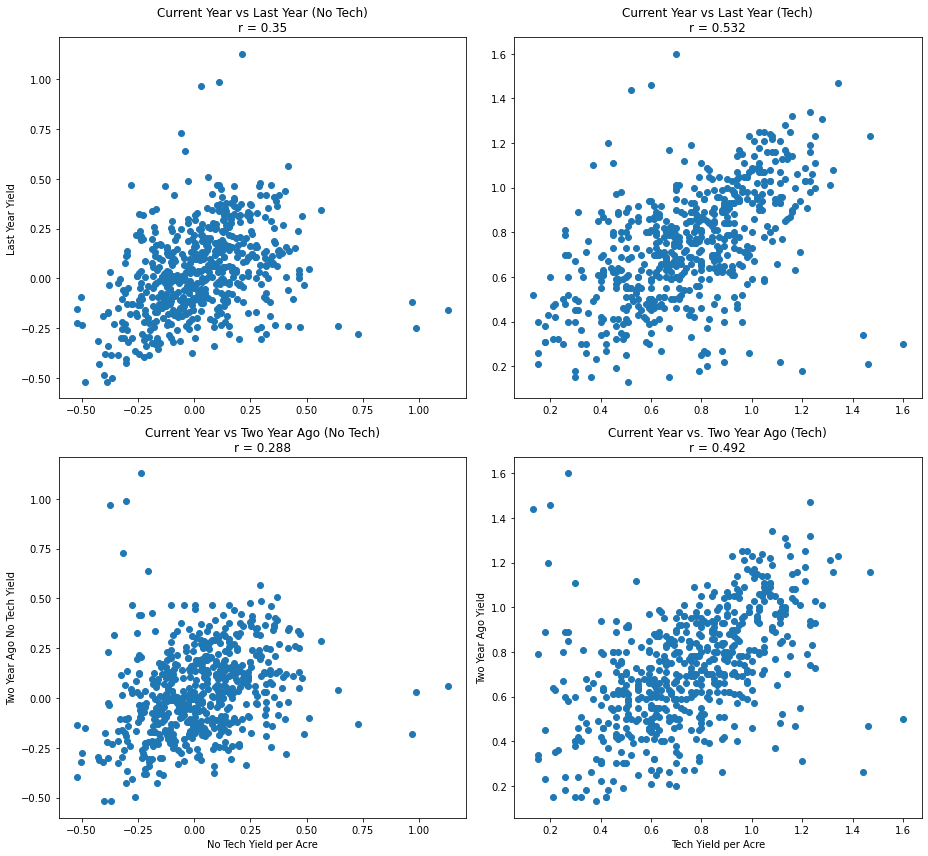

In [0]:
fig, ax = plt.subplots(2,2, sharex = False, sharey = False, figsize = (13,12))


#Corr Coefs for titles
notech_last_year = str(round(np.corrcoef(df_almonds_c['No Tech Yield per Acre'], df_almonds_c['Last Year No Tech Yield'])[0][1],3))
notech_two_year = str(round(np.corrcoef(df_almonds_c['No Tech Yield per Acre'], df_almonds_c['Two Year Ago No Tech Yield'])[0][1],3))

last_year = str(round(np.corrcoef(df_almonds_c['Yield per Acre'], df_almonds_c['Last Year Yield'])[0][1],3))
two_year = str(round(np.corrcoef(df_almonds_c['Yield per Acre'], df_almonds_c['Two Year Ago Yield'])[0][1],3))


ax[0,0].scatter(df_almonds_c['No Tech Yield per Acre'], df_almonds_c['Last Year No Tech Yield'])
ax[0,0].set_ylabel('Last Year No Tech Yield')
ax[0,0].set_title('Current Year vs Last Year (No Tech)\n' + 'r = ' + notech_last_year)

ax[1,0].scatter(df_almonds_c['No Tech Yield per Acre'], df_almonds_c['Two Year Ago No Tech Yield'])
ax[1,0].set_ylabel('Two Year Ago No Tech Yield')
ax[1,0].set_xlabel('No Tech Yield per Acre')
ax[1,0].set_title('Current Year vs Two Year Ago (No Tech)\n' + 'r = ' + notech_two_year)

ax[0,1].scatter(df_almonds_c['Yield per Acre'], df_almonds_c['Last Year Yield'])
ax[0,0].set_ylabel('Last Year Yield')
ax[0,1].set_title('Current Year vs Last Year (Tech)\n' + 'r = ' + last_year)

ax[1,1].scatter(df_almonds_c['Yield per Acre'], df_almonds_c['Two Year Ago Yield'])
ax[1,1].set_ylabel('Two Year Ago Yield')
ax[1,1].set_xlabel('Tech Yield per Acre')
ax[1,1].set_title('Current Year vs. Two Year Ago (Tech)\n' + 'r = ' + two_year)

plt.tight_layout()

In [0]:
#Dict of colors
county_colors = {'Sacramento': 'black',
 'Calaveras': 'silver',
 'Los Angeles': 'rosybrown',
 'Kings': 'firebrick',
 'Placer': 'salmon',
 'Mariposa': 'coral',
 'Monterey': 'sienna',
 'Solano': 'sandybrown',
 'Contra Costa': 'gold',
 'Yolo': 'olive',
 'Yuba': 'darkseagreen',
'San Benito': 'forestgreen',
 'Kern': 'mediumaquamarine',
 'Colusa': 'darkslategrey',
 'Fresno': 'aqua',
 'Madera': 'dodgerblue',
 'Santa Clara': 'navy',
       'Tehama': 'rebeccapurple',
  'San Joaquin': 'thistle',
  'Butte': 'hotpink',
  'Merced': 'pink',
 'Tulare': 'wheat',
 'Stanislaus': 'darkgoldenrod',
  'Sutter': 'orangered',
  'Lake': 'saddlebrown',
  'Glenn': 'khaki',
  'San Luis Obispo': 'lightskyblue'}

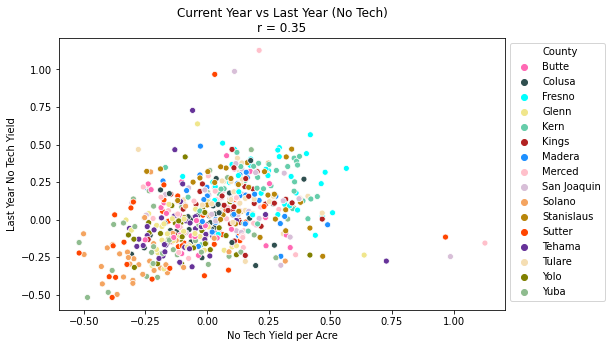

In [0]:
#Color by county for non-tech
fig, ax = plt.subplots(figsize = (8,5))
ax = sns.scatterplot(x = 'No Tech Yield per Acre', y= 'Last Year No Tech Yield', data = df_almonds_c, hue = 'County', palette = county_colors)
ax.set_title('Current Year vs Last Year (No Tech)\n' + 'r = ' + notech_last_year)
plt.legend(bbox_to_anchor = (1,1))

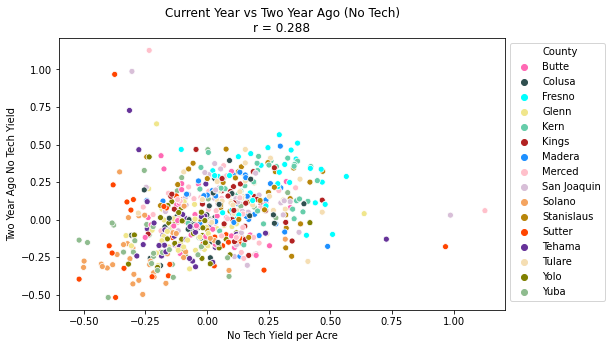

In [0]:
fig, ax = plt.subplots(figsize = (8,5))
ax = sns.scatterplot(x = 'No Tech Yield per Acre', y = 'Two Year Ago No Tech Yield', hue = 'County', data = df_almonds_c, palette = county_colors)
ax. set_title('Current Year vs Two Year Ago (No Tech)\n' + 'r = ' + notech_two_year)
plt.legend(bbox_to_anchor = (1,1))

In [0]:
target = df_almonds_c['No Tech Yield per Acre'].values
predictor = df_almonds_c[['Last Year No Tech Yield', 'Two Year Ago No Tech Yield']].values

model = linear_model.LinearRegression()
model.fit(predictor, target)

alternate_trend = model.predict(predictor)

#Look at R2
print(np.corrcoef(alternate_trend, df_almonds_c['No Tech Yield per Acre'])[0][1]**2)

#Residuals
df_almonds_c['No Tech No Alt Yield per Acre'] = df_almonds_c['No Tech Yield per Acre'] - alternate_trend

0.1550711830205019


**Compare non-AR to AR**

No handles with labels found to put in legend.


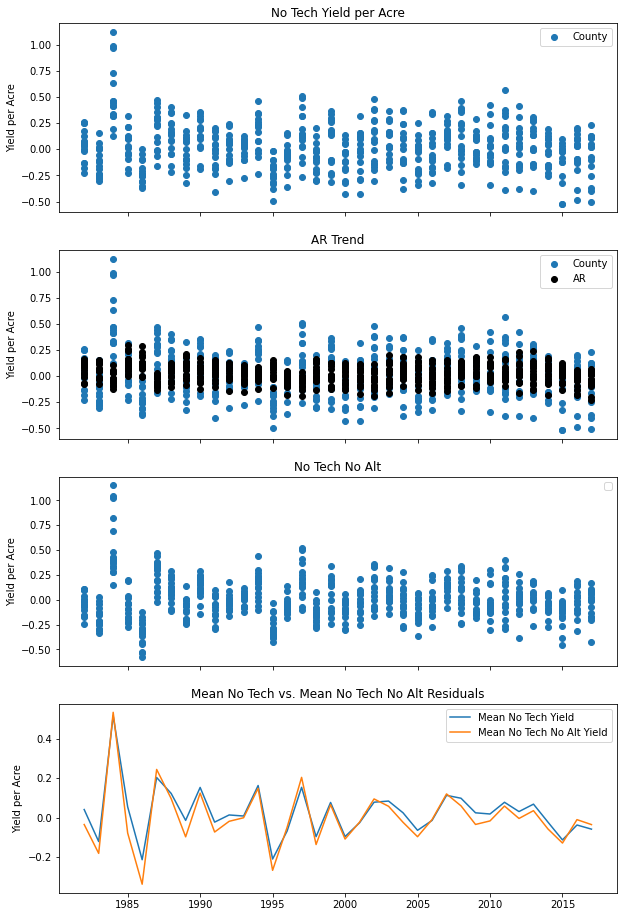

In [0]:
fig, ax = plt.subplots(4, sharex = True, sharey = False, figsize = (10,16))

plt.setp(ax, ylabel = 'Yield per Acre')

ax[0].scatter(df_almonds_c['Year'], df_almonds_c['No Tech Yield per Acre'], label = 'County')
ax[0].set_title('No Tech Yield per Acre')
ax[0].legend(loc = 'upper right')

ax[1].scatter(df_almonds_c['Year'], df_almonds_c['No Tech Yield per Acre'], label = 'County')
ax[1].scatter(df_almonds_c['Year'], alternate_trend, color = 'black', label = 'AR')
ax[1].set_title('AR Trend')
ax[1].legend(loc = 'upper right')

#Plot mean of no tech yield vs mean of no tech no alt yield
ax[2].scatter(df_almonds_c['Year'],df_almonds_c['No Tech No Alt Yield per Acre'])
ax[2].set_title('No Tech No Alt')
ax[2].legend(loc = 'upper right')

#Plot mean of no tech yield vs mean of no tech no alt yield
ax[3].plot(df_almonds_c['Year'].unique(),df_almonds_c.groupby('Year').mean()['No Tech Yield per Acre'], label = 'Mean No Tech Yield')
ax[3].plot(df_almonds_c['Year'].unique(),df_almonds_c.groupby('Year').mean()['No Tech No Alt Yield per Acre'], label = 'Mean No Tech No Alt Yield')
ax[3].set_title('Mean No Tech vs. Mean No Tech No Alt Residuals')
ax[3].legend(loc = 'upper right')

**What happens if we shuffle the observations so they no longer line up?**

In [0]:
#Only select counties that have a complete set of 38 observations
df = df_almonds.groupby('County').count().reset_index()
counties = df.loc[df['Year'] == 38, 'County'].values

#Filtered to complete counties
df_almonds_c = df_almonds[df_almonds['County'].isin(counties)]

#Shuffle the observations (climate and yields) within a year randomly.
#Doing this assumes no difference between counties

#Save correlations and fitted R2
lag_1_corr = []
lag_2_corr = []
R2 = []

for i in range(1000):
  #Store shuffled years here
  years_dict = {}

  #Prepare data
  #Only select counties that have a complete set of 38 observations
  df = df_almonds.groupby('County').count().reset_index()
  counties = df.loc[df['Year'] == 38, 'County'].values

  #Filtered to complete counties
  df_almonds_c = df_almonds[df_almonds['County'].isin(counties)]

  for year in df_almonds_c['Year'].unique():
    df_year = df_almonds_c[df_almonds_c['Year'] == year]
    df_year = df_year.sample(frac = 1)
    years_dict[str(year)] = df_year

  #Concat shuffled years together
  df_almonds_c = pd.concat(years_dict.values())

  #Add two columns that have shifted tech adjusted yields
  df_almonds_c['Last Year No Tech Yield'] = df_almonds_c['No Tech Yield per Acre'].shift(periods = 16)
  df_almonds_c['Two Year Ago No Tech Yield'] = df_almonds_c['No Tech Yield per Acre'].shift(periods = 32)

  #Drop rows with na after shifting
  df_almonds_c = df_almonds_c[df_almonds_c['Year'] > 1981]

  #Save correlation of lag_1 / lag_2 with tech residuals
  lag_1_corr.append(round(np.corrcoef(df_almonds_c['No Tech Yield per Acre'], df_almonds_c['Last Year No Tech Yield'])[0][1],3))
  lag_2_corr.append(round(np.corrcoef(df_almonds_c['No Tech Yield per Acre'], df_almonds_c['Two Year Ago No Tech Yield'])[0][1],3))

  #Fit AR model
  target = df_almonds_c['No Tech Yield per Acre'].values
  predictor = df_almonds_c[['Last Year No Tech Yield', 'Two Year Ago No Tech Yield']].values

  model = linear_model.LinearRegression()
  model.fit(predictor, target)

  alternate_trend = model.predict(predictor)

  #Save model R2
  R2.append(np.corrcoef(alternate_trend, df_almonds_c['No Tech Yield per Acre'])[0][1])

KeyboardInterrupt: ignored

In [0]:
#Results
plt.hist(R2)
plt.title('R2 for AR Model')
plt.show()

plt.hist(lag_1_corr)
plt.title('Correlation Lag 1 vs Tech Residuals')
plt.show()

plt.hist(lag_2_corr)
plt.title('Correlation Lag 2 vs. Tech Residuals')
plt.show()


In [0]:
fig, ax = plt.subplots(2,2, sharex = False, sharey = False, figsize = (13,12))


#Corr Coefs for titles
notech_last_year = str(round(np.corrcoef(df_almonds_c['No Tech Yield per Acre'], df_almonds_c['Last Year No Tech Yield'])[0][1],3))
notech_two_year = str(round(np.corrcoef(df_almonds_c['No Tech Yield per Acre'], df_almonds_c['Two Year Ago No Tech Yield'])[0][1],3))

last_year = str(round(np.corrcoef(df_almonds_c['Yield per Acre'], df_almonds_c['Last Year Yield'])[0][1],3))
two_year = str(round(np.corrcoef(df_almonds_c['Yield per Acre'], df_almonds_c['Two Year Ago Yield'])[0][1],3))


ax[0,0].scatter(df_almonds_c['No Tech Yield per Acre'], df_almonds_c['Last Year No Tech Yield'])
ax[0,0].set_ylabel('Last Year No Tech Yield')
ax[0,0].set_title('Current Year vs Last Year (No Tech)\n' + 'r = ' + notech_last_year)

ax[1,0].scatter(df_almonds_c['No Tech Yield per Acre'], df_almonds_c['Two Year Ago No Tech Yield'])
ax[1,0].set_ylabel('Two Year Ago No Tech Yield')
ax[1,0].set_xlabel('No Tech Yield per Acre')
ax[1,0].set_title('Current Year vs Two Year Ago (No Tech)\n' + 'r = ' + notech_two_year)

ax[0,1].scatter(df_almonds_c['Yield per Acre'], df_almonds_c['Last Year Yield'])
ax[0,0].set_ylabel('Last Year Yield')
ax[0,1].set_title('Current Year vs Last Year (Tech)\n' + 'r = ' + last_year)

ax[1,1].scatter(df_almonds_c['Yield per Acre'], df_almonds_c['Two Year Ago Yield'])
ax[1,1].set_ylabel('Two Year Ago Yield')
ax[1,1].set_xlabel('Tech Yield per Acre')
ax[1,1].set_title('Current Year vs. Two Year Ago (Tech)\n' + 'r = ' + two_year)

plt.tight_layout()

# Scale Predictors

In [0]:
df_almonds_scale_prep = df_almonds_c.drop(columns = ['Commodity Code', 'Crop Name', 'County Code', 'Harvested Acres', 'No Tech Yield per Acre',
                                        'Price per Unit', 'Unit', 'Total Value', 'County', 'Production'])

#Scale
from sklearn.preprocessing import StandardScaler

#Create scaler
scaler = StandardScaler()

#Save a copy of our residuals. We don't want these scaled
almond_no_scale = df_almonds_scale_prep[['No Tech No Alt Yield per Acre', 'Yield per Acre', 'Last Year Yield', 'Two Year Ago Yield']].reset_index(drop = True)

#Fit and transform the data (now an array). Remove columns we don't want scaled
#Here I am still scaling previous years yields
scaled_array = scaler.fit_transform(df_almonds_scale_prep.drop(columns = ['No Tech No Alt Yield per Acre', 'Yield per Acre', 'Last Year Yield', 'Two Year Ago Yield']))

#Convert array back to df
scaled_df = pd.DataFrame(scaled_array, columns = df_almonds_scale_prep.drop(columns = ['No Tech No Alt Yield per Acre', 'Yield per Acre', 'Last Year Yield', 'Two Year Ago Yield']).columns)

#Add the counties and yield per acre back in
almond_scaled = scaled_df.join(almond_no_scale)

**Perform independent regressions between each variables and the yield per acre**

In [0]:
#Include squares
R2_dict = {}
for var in almond_scaled.columns:
  if var in ['No Tech No Alt Yield per Acre', 'Yield per Acre', 'Last Year Yield', 'Two Year Ago Yield', 'Year']:
    continue

  else:
    climate_var = var
    climate_var_2 = climate_var + '_2'

    var_selection = almond_scaled[[climate_var, 'No Tech No Alt Yield per Acre']]
    var_selection[climate_var_2] = var_selection[climate_var]**2

    target = var_selection['No Tech No Alt Yield per Acre'].values
    predictors = var_selection.drop(columns = 'No Tech No Alt Yield per Acre').values

    model = linear_model.LinearRegression()
    model.fit(predictors, target)

    R2 = np.corrcoef(target,model.predict(predictors))[0][1]
    R2_dict[var] = [R2]



In [0]:
#Squares
plot_R2 = pd.DataFrame.from_dict(R2_dict).T.sort_values(by = 0).reset_index().rename(columns = {'index':'Var', 0:'R2'})
plot_R2 = plot_R2.tail(10)

#Add for later
plot_R2['Squares'] = 'Yes'
yes_squares_plot_R2 = plot_R2

fig, ax = plt.subplots(figsize = (8,5))
ax = sns.barplot(x = 'Var', y = 'R2', data = yes_squares_plot_R2, color = 'steelblue')
plt.xticks(rotation = 90)

ax.set_title('R2 Based on Exploratory Analysis')

In [0]:
#No squares
R2_dict = {}
for var in almond_scaled.columns:
    if var in ['No Tech No Alt Yield per Acre', 'Yield per Acre', 'Last Year Yield', 'Two Year Ago Yield', 'Year']:
      continue

    else:
    
      climate_var = var

      var_selection = almond_scaled[[climate_var, 'No Tech No Alt Yield per Acre']]

      target = var_selection['No Tech No Alt Yield per Acre'].values
      predictors = var_selection.drop(columns = 'No Tech No Alt Yield per Acre').values
      predictor_formatted = np.reshape(predictors, (len(predictors), 1))

      model = linear_model.LinearRegression()
      model.fit(predictor_formatted, target)

      R2 = np.corrcoef(target,model.predict(predictors))[0][1]
      R2_dict[var] = [R2]

In [0]:
# No squares
plot_R2 = pd.DataFrame.from_dict(R2_dict).T.sort_values(by = 0).reset_index().rename(columns = {'index':'Var', 0:'R2'})
plot_R2 = plot_R2.tail(10)

#Add for later
plot_R2['Squares'] = 'No'
no_squares_plot_R2 = plot_R2

fig, ax = plt.subplots(figsize = (8,5))
ax = sns.barplot(x = 'Var', y = 'R2', data = no_squares_plot_R2, color = 'steelblue')
plt.xticks(rotation = 90)

ax.set_title('R2 Based on Exploratory Analysis')

**Squares vs no squares together**

In [0]:
#not sure why get an empty plot...
plot_R2 = pd.concat([no_squares_plot_R2, yes_squares_plot_R2])

fig, ax = plt.subplots(figsize = (8,5))

ax = sns.catplot(x = 'Var', y='R2', hue = 'Squares', data=plot_R2, kind='bar', palette = 'Purples')
ax.set_xticklabels(rotation = 90)



In [0]:
#Function to convert months to numbers

def word_to_num(word):

  x = word.split('_')[0]

  if x == 'January':
    return 1
  elif x == 'February':
    return 2
  elif x == 'March':
    return 3
  elif x == 'April':
    return 4
  elif x == 'May':
    return 5
  elif x == 'June':
    return 6
  elif x == 'July':
    return 7
  elif x == 'August':
    return 8
  elif x == 'September':
    return 9
  elif x == 'October':
    return 10
  elif x == 'November':
    return 11
  elif x == 'December':
    return 12

In [0]:
plot_R2 = pd.DataFrame.from_dict(R2_dict).T.sort_values(by = 0).reset_index().rename(columns = {'index':'Var', 0:'R2'})

df_tmin = plot_R2[plot_R2['Var'].str.contains('tmin')]
df_tmax = plot_R2[plot_R2['Var'].str.contains('tmax')]
df_tmean = plot_R2[plot_R2['Var'].str.contains('tmean')]
df_ppt = plot_R2[plot_R2['Var'].str.contains('ppt')]
df_vpdmin = plot_R2[plot_R2['Var'].str.contains('vpdmin')]
df_vpdmax = plot_R2[plot_R2['Var'].str.contains('vpdmax')]

df_tmin['Month'] = df_tmin['Var'].apply(word_to_num)
df_tmax['Month'] = df_tmax['Var'].apply(word_to_num)
df_tmean['Month'] = df_tmean['Var'].apply(word_to_num)
df_ppt['Month'] = df_ppt['Var'].apply(word_to_num)
df_vpdmin['Month'] = df_vpdmin['Var'].apply(word_to_num)
df_vpdmax['Month'] = df_vpdmax['Var'].apply(word_to_num)


In [0]:
fig, ax = plt.subplots(figsize = (12,5))
ax = sns.lineplot(x = 'Month', y = 'R2', data = df_tmin, color = 'black', label = 'Tmin')
ax = sns.lineplot(x = 'Month', y = 'R2', data = df_tmax, color = 'blue', label = 'Tmax')
#ax = sns.lineplot(x = 'Month', y = 'R2', data = df_tmean, color = 'orange')
ax = sns.lineplot(x = 'Month', y = 'R2', data = df_ppt, color = 'purple', label = 'ppt')
ax = sns.lineplot(x = 'Month', y = 'R2', data = df_vpdmin, color = 'pink', label = 'VPDmin')
ax = sns.lineplot(x = 'Month', y = 'R2', data = df_vpdmax, color = 'green', label = 'VPDmax')

ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'])
ax.set_title('R2 For Regression Between Monthly Mean Variable and Detrended Almond Yields')
plt.legend(bbox_to_anchor = (1,1))

**Significance testing.**

In [0]:
#What values of R2 are significant. Create random variable and make model. Create R2 distribution through simulation.

simulated_R2 = []

for i in range(1000):

  random_variable = np.random.normal(size = 576)
  random_variable_2 = [i**2 for i in random_variable]

  x = pd.Series(random_variable)
  y = pd.Series(random_variable_2)
  random_series = pd.concat([x,y], axis = 1)

  target = almond_scaled['No Tech No Alt Yield per Acre'].values
  predictors = random_series.values

  model = linear_model.LinearRegression()
  model.fit(predictors, target)

  R2 = np.corrcoef(target,model.predict(predictors))[0][1]
  simulated_R2.append(R2)

**Plot null distribution**

In [0]:
percentile_99th = np.percentile(simulated_R2, 99)
fig, ax = plt.subplots(figsize = (8,5))
ax.hist(simulated_R2, color = 'purple')
ax.axvline(percentile_99th, color = 'black', label = '99th percentile')
ax.set_title('R2 Null Distribution\n n = 1000')
plt.legend(loc = 'upper center')


In [0]:
fig, ax = plt.subplots(figsize = (12,5))

#R2 values each month
ax = sns.lineplot(x = 'Month', y = 'R2', data = df_tmin, color = 'black', label = 'Tmin')
ax = sns.lineplot(x = 'Month', y = 'R2', data = df_tmax, color = 'blue', label = 'Tmax')
#ax = sns.lineplot(x = 'Month', y = 'R2', data = df_tmean, color = 'orange', label = 'Tmean')
ax = sns.lineplot(x = 'Month', y = 'R2', data = df_ppt, color = 'purple', label = 'PPT')
ax = sns.lineplot(x = 'Month', y = 'R2', data = df_vpdmin, color = 'pink', label = 'VPDmin')
ax = sns.lineplot(x = 'Month', y = 'R2', data = df_vpdmax, color = 'green', label = 'VPDmax')

#Significance level
ax.hlines(y = percentile_99th, xmin = 1, xmax = 12, linestyle = 'dashed', label = '99th perc of null dist')

#Formatting
ax.set_title('R2 For Regression Between Yield And Monthly Climate Variable', fontsize = 15)
ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'])

plt.legend()

**Need to figure out how to do significance testing for correlation. How will we be able to determine the effect of one variable from another?**

In [0]:
#Collect correlations
ppt_tmax = []
ppt_tmin = []
ppt_vpdmax = []
ppt_vpdmin = []

tmax_tmin = []
tmax_vpdmax = []
tmax_vpdmin = []

tmin_vpdmax = []
tmin_vpdmin = []

vpdmax_vpdmin = []

months = ['January', 'February', 'March',
              'April', 'May', 'June',
              'July', 'August', 'September',
              'October','November', 'December']

#Cycle through month
for month in months:

  #Store climate variables for given month
  month_vars = []

  for i in almond_scaled.columns.values:
    if month in i:
      month_vars.append(i)
    else:
      continue

  #Filter down to only given month variables. Make corr matrix
  month_filter = almond_scaled[month_vars]
  corr_matrix = month_filter.corr()

  #Extract corr values
  ppt_tmax.append(corr_matrix.iloc[1,0])
  ppt_tmin.append(corr_matrix.iloc[2,0])
  ppt_vpdmax.append(corr_matrix.iloc[4,0])
  ppt_vpdmin.append(corr_matrix.iloc[5,0])

  tmax_tmin.append(corr_matrix.iloc[2,1])
  tmax_vpdmax.append(corr_matrix.iloc[4,1])
  tmax_vpdmin.append(corr_matrix.iloc[5,1])

  tmin_vpdmax.append(corr_matrix.iloc[4,2])
  tmin_vpdmin.append(corr_matrix.iloc[5,2])

  vpdmax_vpdmin.append(corr_matrix.iloc[5,4])

#Make dfs
df_ppt_tmax = pd.DataFrame(list(zip(months,ppt_tmax)), columns = ['Month', 'Corr'])
df_ppt_tmin = pd.DataFrame(list(zip(months,ppt_tmin)), columns = ['Month', 'Corr'])
df_ppt_vpdmax = pd.DataFrame(list(zip(months,ppt_vpdmax)), columns = ['Month', 'Corr'])
df_ppt_vpdmin = pd.DataFrame(list(zip(months,ppt_vpdmin)), columns = ['Month', 'Corr'])

df_tmax_tmin = pd.DataFrame(list(zip(months,tmax_tmin)), columns = ['Month', 'Corr'])
df_tmax_vpdmax = pd.DataFrame(list(zip(months,tmax_vpdmax)), columns = ['Month', 'Corr'])
df_tmax_vpdmin = pd.DataFrame(list(zip(months,tmax_vpdmin)), columns = ['Month', 'Corr'])

df_tmin_vpdmax = pd.DataFrame(list(zip(months,tmin_vpdmax)), columns = ['Month', 'Corr'])
df_tmin_vpdmin = pd.DataFrame(list(zip(months,tmin_vpdmin)), columns = ['Month', 'Corr'])

df_vpdmax_vpdmin = pd.DataFrame(list(zip(months,vpdmax_vpdmin)), columns = ['Month', 'Corr'])

#Word to num
df_ppt_tmax['Month_num'] = df_ppt_tmax['Month'].apply(word_to_num)
df_ppt_tmin['Month_num'] = df_ppt_tmin['Month'].apply(word_to_num)
df_ppt_vpdmax['Month_num'] = df_ppt_vpdmax['Month'].apply(word_to_num)
df_ppt_vpdmin['Month_num'] = df_ppt_vpdmin['Month'].apply(word_to_num)

df_tmax_tmin['Month_num'] = df_tmax_tmin['Month'].apply(word_to_num)
df_tmax_vpdmax['Month_num'] = df_tmax_vpdmax['Month'].apply(word_to_num)
df_tmax_vpdmin['Month_num'] = df_tmax_vpdmin['Month'].apply(word_to_num)

df_tmin_vpdmax['Month_num'] = df_tmin_vpdmax['Month'].apply(word_to_num)
df_tmin_vpdmin['Month_num'] = df_tmin_vpdmin['Month'].apply(word_to_num)

df_vpdmax_vpdmin['Month_num'] = df_vpdmax_vpdmin['Month'].apply(word_to_num)

In [0]:
fig, ax = plt.subplots(4,4, sharex = True, sharey = False, figsize = (10,10))

plt.setp(ax, xticks=np.arange(1,13), xticklabels=['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'], ylim = (-1,1) )

ax[3,3].plot(df_ppt_tmax['Month_num'], df_ppt_tmax['Corr'])
ax[3,3].set_title('PPT Tmax')

ax[2,3].plot(df_ppt_tmin['Month_num'], df_ppt_tmin['Corr'])
ax[2,3].set_title('PPT Tmin')

ax[1,3].plot(df_ppt_vpdmax['Month_num'], df_ppt_vpdmax['Corr'])
ax[1,3].set_title('PPT VPDmax')

ax[0,3].plot(df_ppt_vpdmin['Month_num'], df_ppt_vpdmin['Corr'])
ax[0,3].set_title('PPT VPDmin')

ax[3,2].plot(df_tmax_tmin['Month_num'], df_tmax_tmin['Corr'])
ax[3,2].set_title('Tmax Tmin')

ax[2,2].plot(df_tmax_vpdmax['Month_num'], df_tmax_vpdmax['Corr'])
ax[2,2].set_title('Tmax VPDmax')

ax[1,2].plot(df_tmax_vpdmin['Month_num'], df_tmax_vpdmin['Corr'])
ax[1,2].set_title('Tmax VPDmin')

ax[3,1].plot(df_tmin_vpdmax['Month_num'], df_tmin_vpdmax['Corr'])
ax[3,1].set_title('Tmin VPDmax')

ax[2,1].plot(df_tmin_vpdmin['Month_num'], df_tmin_vpdmin['Corr'])
ax[2,1].set_title('Tmin VPDmin')

ax[3,0].plot(df_vpdmax_vpdmin['Month_num'], df_vpdmax_vpdmin['Corr'])
ax[3,0].set_title('VPDmax VPDmin')

#Delete extra axes
fig.delaxes(ax[0,0])
fig.delaxes(ax[1,0])
fig.delaxes(ax[2,0])
fig.delaxes(ax[0,1])
fig.delaxes(ax[1,1])
fig.delaxes(ax[0,2])

fig.tight_layout()

**Model: Predict raw yield with two climate variables, previous two years yields, and year**

In [0]:
var_selection = almond_scaled[['Year','March_ppt', 'February_tmin','Last Year Yield', 'Two Year Ago Yield']]
df_almonds_c = df_almonds_c.reset_index(drop = True)
data = pd.concat([var_selection, df_almonds_c['Yield per Acre']], axis = 1)

target = data['Yield per Acre'].values
predictors = data.drop(columns = 'Yield per Acre')
predictor_values = predictors.values

model = linear_model.LinearRegression()
model.fit(predictor_values, target)

R2 = np.corrcoef(target,model.predict(predictor_values))[0][1]
R2

In [0]:
#Quick function to determine if coef is + or -
def plus_or_minus(x):
  if x < 0:
    return 'N'
  else:
    return 'P'

In [0]:
df = pd.DataFrame({'Vars': predictors.columns, 'Coef':model.coef_})
df['Sign'] = df['Coef'].apply(plus_or_minus)
df['Abs Coef'] = df['Coef'].abs()

df = df.sort_values(by = 'Abs Coef')

fig, ax = plt.subplots(figsize = (8,5))
ax = sns.barplot(x = 'Vars', y = 'Abs Coef', data = df, hue = 'Sign')

**Model: Predict raw yield with year and two climate variables**

In [0]:
var_selection = almond_scaled[['Year','March_ppt', 'February_tmin']]
df_almonds_c = df_almonds_c.reset_index(drop = True)
data = pd.concat([var_selection, df_almonds_c['Yield per Acre']], axis = 1)

target = data['Yield per Acre'].values
predictors = data.drop(columns = 'Yield per Acre')
predictor_values = predictors.values

model = linear_model.LinearRegression()
model.fit(predictor_values, target)

R2 = np.corrcoef(target,model.predict(predictor_values))[0][1]
R2

In [0]:
df_y_c = pd.DataFrame({'Vars': predictors.columns, 'Coef':model.coef_})
df_y_c['Sign'] = df_y_c['Coef'].apply(plus_or_minus)
df_y_c['Abs Coef'] = df_y_c['Coef'].abs()

df_y_c = df_y_c.sort_values(by = 'Abs Coef')

sns.barplot(x = 'Vars', y = 'Abs Coef', data = df_y_c, hue = 'Sign')

**Model: Predict raw yields only using year**

In [0]:
var_selection = almond_scaled[['Year']]
df_almonds_c = df_almonds_c.reset_index(drop = True)
data = pd.concat([var_selection, df_almonds_c['Yield per Acre']], axis = 1)

target = data['Yield per Acre'].values
predictors = data.drop(columns = 'Yield per Acre')
predictor_values = predictors.values

model = linear_model.LinearRegression()
model.fit(predictor_values, target)

R2 = np.corrcoef(target,model.predict(predictor_values))[0][1]
R2

In [0]:
df_y = pd.DataFrame({'Vars': predictors.columns, 'Coef':model.coef_})
df_y['Sign'] = df_y['Coef'].apply(plus_or_minus)
df_y['Abs Coef'] = df_y['Coef'].abs()

df_y = df_y.sort_values(by = 'Abs Coef')

sns.barplot(x = 'Vars', y = 'Abs Coef', data = df_y)

The year cofficient in the model including the year and the two climate variables represents the yield trend AFTER climate has been accounted for. For the model with only the year term, the year coefficient represents before the climate variables were accounted for. 

Coef including climate variables / Coef wo climate variables

In [0]:
df_y_c.loc[df_y_c['Vars'] == 'Year', 'Coef'] / df_y.loc[df_y['Vars'] == 'Year', 'Coef']

**So it looks like past climate has not had much of an affect on almond yields.**

# **LASSO Bootstrapping**

In [0]:
import random
from sklearn import linear_model
from sklearn.linear_model import LassoCV

In [0]:
df = pd.concat([almond_scaled, df_almonds_c[['County']]], axis = 1)

#Climate variables only. Drop non-climate.
df = df.drop(columns = ['Year', 'Two Year Ago No Tech Yield', 'Yield per Acre', 'Last Year Yield',
                        'Two Year Ago Yield', 'Last Year No Tech Yield'])

#Make list of training and testing counties
counties = list(df['County'].unique())

#Collect results
R2_train = []
R2_test = []

for i in range(100):
  test_counties = random.sample(counties, 4)
  train_counties = []

  for c in counties:
    if c not in test_counties:
      train_counties.append(c)
    else:
      continue

  #Split the data into train and test
  train = df[df['County'].isin(train_counties)]
  test = df[df['County'].isin(test_counties)]

  #Drop the county column
  train = train.drop(columns = ['County'])
  test = test.drop(columns = ['County'])

  #Split train/test into predictors and targets
  x_train = train.drop(columns = ['No Tech No Alt Yield per Acre']).values
  y_train = train['No Tech No Alt Yield per Acre'].values

  x_test = test.drop(columns = ['No Tech No Alt Yield per Acre']).values
  y_test = test['No Tech No Alt Yield per Acre'].values

  #LassoCV to determine alpha based on training data
  lassoCV = linear_model.LassoCV(eps=0.0001, n_alphas=400, max_iter=200000, cv= 4, normalize=False, fit_intercept = True)  # pass it to the cv argument
  lassoCV.fit(x_train, y_train)

  #Create lasso object
  lasso = linear_model.Lasso(max_iter = 200000, normalize = False, fit_intercept = True)

  #Make final Lasso model with alpha value from CV
  lasso.set_params(alpha=lassoCV.alpha_)
  lasso.fit(x_train, y_train)

  #Results
  R2_train.append(np.corrcoef(y_train, lasso.predict(x_train))[0][1]**2)
  R2_test.append(np.corrcoef(y_test, lasso.predict(x_test))[0][1]**2)

  if i%10 == 0:
    print(i)

In [0]:
#Results from using 2/3 counties to calibrate and 1/3 to test
fig, ax = plt.subplots(figsize = (8,5))
ax.boxplot([R2_train, R2_test])
ax.set_xticklabels(['Train', 'Test'])

ax.set_title('Almond Model R2\n n = 100')

In [0]:
#Results from using 2/3 counties to calibrate and 1/3 to test
fig, ax = plt.subplots(figsize = (8,5))
ax.boxplot([R2_train, R2_test], notch = True)
ax.set_xticklabels(['Train', 'Test'])

ax.set_title('Almond Model R2\n n = 100')

# Coefs

## Train/Test on All Almond Data
(no validation set)

In [0]:
df = almond_scaled
df = df.drop(columns = ['Year', 'Two Year Ago No Tech Yield', 'Yield per Acre', 'Last Year Yield',
                       'Two Year Ago Yield', 'Last Year No Tech Yield'])
#Collect results
R2_train = []

#Split train/test into predictors and targets
x_train = df.drop(columns = ['No Tech No Alt Yield per Acre']).values
y_train = df['No Tech No Alt Yield per Acre'].values

#LassoCV to determine alpha based on training data
lassoCV = linear_model.LassoCV(eps=0.0001, n_alphas=400, max_iter=200000, cv= 4, normalize=False, fit_intercept = True)  # pass it to the cv argument
lassoCV.fit(x_train, y_train)

#Create lasso object
lasso = linear_model.Lasso(max_iter = 200000, normalize = False, fit_intercept = True)

#Make final Lasso model with alpha value from CV
lasso.set_params(alpha=lassoCV.alpha_)
lasso.fit(x_train, y_train)

#Results
R2_train.append(np.corrcoef(y_train, lasso.predict(x_train))[0][1]**2)

print(R2_train)

In [0]:
#Function to determine what variable each coef is for
def var_to_word(word):

  x = word.split('_')[1]

  if x == 'tmax':
    return 'TMAX'
  elif x == 'tmin':
    return 'TMIN'
  elif x == 'ppt':
    return 'PPT'
  elif x == 'vpdmin':
    return 'VPDMIN'
  elif x == 'vpdmax':
    return 'VPDMAX'
  elif x == 'tmean':
    return 'TMEAN'

In [0]:
#Make df from results
predictors = df.drop(columns = ['No Tech No Alt Yield per Acre', 'County']).columns
df_coefs = pd.DataFrame.from_dict({'Predictors': predictors, 'Coef':lasso.coef_})

df_coefs['Month'] = df_coefs['Predictors'].apply(word_to_num)
df_coefs['Var'] = df_coefs['Predictors'].apply(var_to_word)

In [0]:
#Plot Coefs

#Pretty colors
var_colors = {'TMIN':'blue', 'TMAX':'red',
              'TMEAN':'black', 'PPT':'olive',
              'VPDMIN':'pink', 'VPDMAX':'purple'}

fig, ax = plt.subplots(figsize = (8,5))

ax = sns.barplot(x = 'Month',y = 'Coef', hue = 'Var', data = df_coefs, palette = var_colors)

ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'])

ax.set_title('Coefs\nPredict All Almond Data')

## Coefs for seperate train/test sets
100 iterations

In [0]:
df = pd.concat([almond_scaled, df_almonds_c[['County']]], axis = 1)

#Climate variables only
df = df.drop(columns = ['Year', 'Two Year Ago No Tech Yield', 'Yield per Acre', 'Last Year Yield',
                        'Two Year Ago Yield', 'Last Year No Tech Yield'])

#Collect results
R2_train = []
R2_test = []
all_coefs = []

for i in range(100):

  #Split training and testing
  df_test = df.sample(144)
  df_train = df.drop(df_test.index)

  #Drop the county column
  df_train = df_train.drop(columns = ['County'])
  df_test = df_test.drop(columns = ['County'])

  #Split train/test into predictors and targets
  x_train = df_train.drop(columns = ['No Tech No Alt Yield per Acre']).values
  y_train = df_train['No Tech No Alt Yield per Acre'].values

  x_test = df_test.drop(columns = ['No Tech No Alt Yield per Acre']).values
  y_test = df_test['No Tech No Alt Yield per Acre'].values

  #LassoCV to determine alpha based on training data
  lassoCV = linear_model.LassoCV(eps=0.0001, n_alphas=400, max_iter=200000, cv= 4, normalize=False, fit_intercept = True)  # pass it to the cv argument
  lassoCV.fit(x_train, y_train)

  #Create lasso object
  lasso = linear_model.Lasso(max_iter = 200000, normalize = False, fit_intercept = True)

  #Make final Lasso model with alpha value from CV
  lasso.set_params(alpha=lassoCV.alpha_)
  lasso.fit(x_train, y_train)

  #R2 Results
  R2_train.append(np.corrcoef(y_train, lasso.predict(x_train))[0][1]**2)
  R2_test.append(np.corrcoef(y_test, lasso.predict(x_test))[0][1]**2)

  #Coef results
  predictors = df.drop(columns = ['No Tech No Alt Yield per Acre', 'County']).columns
  df_coefs = pd.DataFrame.from_dict({'Predictors': predictors, 'Coef':lasso.coef_})

  unique_name = 'Coef_' + str(i)

  df_coefs = df_coefs.rename(columns = {'Coef':unique_name})

  all_coefs.append(df_coefs)

  if i%10 == 0:
    print(i)

In [0]:
#Set the predictors to the index for all dfs
dfs = [df.set_index('Predictors') for df in all_coefs]

#Concat all dfs together
df_coefs = pd.concat(dfs, axis = 1).reset_index()

#Calculate mean and stdev for each predictor
df_coefs['Mean'] = df_coefs.mean(axis = 1)
df_coefs['STD'] = df_coefs.std(axis = 1)

#Following emprical rule see if zero is contained within +/- 2STD of mean
def CI_contains_zero(x):

  lower_bound = x['Mean'] - (2*x['STD'])
  upper_bound = x['Mean'] + (2*x['STD'])

  if (0 > lower_bound) & (0 > upper_bound):
    return 'No'
  
  elif (0 > lower_bound) & (0 < upper_bound):
    return 'Yes'

  elif (0 < lower_bound) & (0 < upper_bound):
    return 'No'

def sd_2(x):
  lower_bound = x['Mean'] - (2*x['STD'])
  upper_bound = x['Mean'] + (2*x['STD'])

  return (lower_bound, upper_bound)

#Apply functions
df_coefs['Contains Zero'] = df_coefs[['Mean', 'STD']].apply(CI_contains_zero, axis = 1)
df_coefs['SD_2 Interval'] = df_coefs[['Mean', 'STD']].apply(sd_2, axis = 1)

#Which predictors do not contain zero?
coefs_select = df_coefs[df_coefs['Contains Zero'] == 'No'][['Predictors', 'Mean', 'STD', 'Contains Zero', 'SD_2 Interval']]
coefs_select

In [0]:
lower_bound = []
upper_bound = []
for i in coefs_select['SD_2 Interval']:
  lower_bound.append(i[0])
  upper_bound.append(i[1])

errors = np.column_stack((lower_bound, upper_bound)).T

In [0]:
errors

In [0]:
coefs_select['Predictors']

In [0]:
coefs_select['Predictors'].values

In [0]:
x = np.arange(0,7)
y = coefs_select['Mean'].values

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(x, y, errors, fmt='r^')
ax.set_xticklabels(coefs_select['Predictors'].values, rotation = 90)
plt.show()

In [0]:
[coefs_select['SD_2 Interval'].values]

In [0]:
yerr.T.shape

In [0]:
predictors = df.drop(columns = ['No Tech No Alt Yield per Acre', 'County']).columns
df_coefs = pd.DataFrame.from_dict({'Predictors': predictors, 'Coef':lasso.coef_})

unique_name = 'Coef_' + str(i)

df_coefs = df_coefs.rename(columns = {'Coef':unique_name})



In [0]:
var_selection = almond_scaled[['Year','March_ppt', 'February_tmin']]
df_almonds_c = df_almonds_c.reset_index(drop = True)
data = pd.concat([var_selection, df_almonds_c['Yield per Acre']], axis = 1)

target = data['Yield per Acre'].values
predictors = data.drop(columns = 'Yield per Acre')
predictor_values = predictors.values

model = linear_model.LinearRegression()
model.fit(predictor_values, target)

R2 = np.corrcoef(target,model.predict(predictor_values))[0][1]
R2

In [0]:
print(list(zip(predictors.columns,model.coef_)))

In [0]:
var_selection = almond_scaled[['Year']]
df_almonds_c = df_almonds_c.reset_index(drop = True)
data = pd.concat([var_selection, df_almonds_c['Yield per Acre']], axis = 1)

target = data['Yield per Acre'].values
predictors = data.drop(columns = 'Yield per Acre')
predictor_values = predictors.values

model = linear_model.LinearRegression()
model.fit(predictor_values, target)

R2 = np.corrcoef(target,model.predict(predictor_values))[0][1]
R2

In [0]:
print(list(zip(predictors.columns,model.coef_)))

In [0]:
print(df_almonds.shape)
print(data.shape)

In [0]:
#Fit final model with year and two variables
#But what about the alternate bearing? NEed to include previous two years yields

var_selection = almond_scaled[['Year','March_ppt', 'February_tmin','Last Year Yield', 'Two Year Ago Yield']]
df_almonds_c = df_almonds_c.reset_index(drop = True)
data = pd.concat([var_selection, df_almonds_c['Yield per Acre']], axis = 1)

for col in data.columns:

  if col in ['Year', 'Yield per Acre', 'Last Year Yield', 'Two Year Ago Yield']:
    continue

  else:
    squared_name = col + '_2'
    print(squared_name)
    data[squared_name] = data[col]**2


target = data['Yield per Acre'].values
predictors = data.drop(columns = 'Yield per Acre')
predictor_values = predictors.values

model = linear_model.LinearRegression()
model.fit(predictor_values, target)

R2 = np.corrcoef(target,model.predict(predictor_values))[0][1]
R2

In [0]:
model.coef_
print(list(zip(predictors.columns,model.coef_)))

In [0]:
#Fit final model with year only

var_selection = almond_scaled[['Year']]
df_almonds_c = df_almonds_c.reset_index(drop = True)
data = pd.concat([var_selection, df_almonds_c['Yield per Acre']], axis = 1)

target = data['Yield per Acre'].values
predictors = data.drop(columns = 'Yield per Acre')
predictor_values = predictors.values

model = linear_model.LinearRegression()
model.fit(predictor_values, target)

R2 = np.corrcoef(target,model.predict(predictor_values))[0][1]
R2

In [0]:
model.coef_
print(list(zip(predictors.columns,model.coef_)))

In [0]:
0.13661596117693725/0.14163243223899452

**Final model but predicting residuals.**

In [0]:
#Fit final model with year and two variables

var_selection = almond_scaled[['March_ppt', 'February_tmin']]
df_almonds_c = df_almonds_c.reset_index(drop = True)
data = pd.concat([var_selection, df_almonds_c['No Tech No Alt Yield per Acre']], axis = 1)

for col in data.columns:

  if col in ['Year', 'No Tech No Alt Yield per Acre']:
    continue

  else:
    squared_name = col + '_2'
    print(squared_name)
    var_selection[squared_name] = var_selection[col]**2


target = data['No Tech No Alt Yield per Acre'].values
predictors = data.drop(columns = 'No Tech No Alt Yield per Acre').values

model = linear_model.LinearRegression()
model.fit(predictors, target)

R2 = np.corrcoef(target,model.predict(predictors))[0][1]
R2

In [0]:
df_almonds_c

In [0]:
#Make a copy of yied columb but shift it down 30 rows so it is lagged by 1 year
#We remove 1980 because there are no lagged values since data begins in 1980
df_resample['Last Year Yield'] = df_resample['No Tech Yield per Acre'].shift(periods = 30)
df_resample['Two Year Ago Yield'] = df_resample['No Tech Yield per Acre'].shift(periods = 60)
df_resample = df_resample[df_resample['Year'] > 1981]

In [0]:
df_resample[df_resample['Year'] == 1983]

In [0]:
from sklearn import linear_model

target = df_resample['No Tech Yield per Acre'].values
predictor = df_resample[['Last Year Yield', 'Two Year Ago Yield']].values
#predictor_formatted = np.reshape(predictor, (len(predictor), 1))
model = linear_model.LinearRegression()
model.fit(predictor, target)

np.corrcoef(target, model.predict(predictor))

In [0]:
predictor

In [0]:
#Plotting lagged vs in year yields does not seem to reveal anything
sns.scatterplot(x = 'No Tech Yield per Acre', y = 'Previous Year Yield', data = df_resample)
np.corrcoef(df_resample['No Tech Yield per Acre'], df_resample['Previous Year Yield'])

In [0]:
from statsmodels.tsa.ar_model import AR
model = AR(df_resample['No Tech Yield per Acre'].values)
model_fit = model.fit(ic = 'aic')
print(model_fit.k_ar)

In [0]:
df_resample

In [0]:
df_climate = df_almonds.drop(columns = ['Commodity Code', 'Crop Name', 'County Code', 'Harvested Acres', 'Yield per Acre',
                                        'Price per Unit', 'Unit', 'Total Value', 'No Tech Yield per Acre','Unnamed: 0', 'County', 'Year', 'Production'])

**Offset yields within each county**

In [0]:
df_almonds[df_almonds['County'] == 'San Luis Obispo']

**Exploratory analysis by regressions. Note that did not use autoregressive model!**

In [0]:
R2_dict = {}
for var in df_climate.columns:
  climate_var = var
  climate_var_2 = climate_var + '_2'

  var_selection = df_almonds[[climate_var, 'No Tech Yield per Acre']]
  var_selection[climate_var_2] = var_selection[climate_var]**2

  target = var_selection['No Tech Yield per Acre'].values
  predictors = var_selection.drop(columns = 'No Tech Yield per Acre').values

  model = linear_model.LinearRegression()
  model.fit(predictors, target)

  R2 = np.corrcoef(target,model.predict(predictors))[0][1]
  R2_dict[var] = [R2]

In [0]:
plot_R2 = pd.DataFrame.from_dict(R2_dict).T.sort_values(by = 0).reset_index().rename(columns = {'index':'Var', 0:'R2'})
plot_R2 = plot_R2.tail(10)

fig, ax = plt.subplots(figsize = (8,5))
ax = sns.barplot(x = 'Var', y = 'R2', data = plot_R2, color = 'steelblue')
plt.xticks(rotation = 90)

ax.set_title('R2 Based on Exploratory Analysis')

**Lobell claims that February_tmin and Jan_ppt had strongest relationship with yield. Scatter plots of these to see if any correlation.**

In [0]:
#What is the relationship between Feb tmin and yield per acre
fig, ax = plt.subplots(figsize = (8,5))
ax = sns.scatterplot(x = 'February_tmin', y = 'No Tech Yield per Acre', data = df_almonds)

R = np.corrcoef(df_almonds['February_tmin'], df_almonds['No Tech Yield per Acre'])[0][1]

ax.set_title('Yield per Acre vs Feb Tmin\n R = ' + str(round(R,3)))

In [0]:
#What is the relationship between Feb tmin and yield per acre
fig, ax = plt.subplots(figsize = (8,5))
ax = sns.scatterplot(x = 'July_vpdmin', y = 'No Tech Yield per Acre', data = df_almonds)

R = np.corrcoef(df_almonds['July_vpdmin'], df_almonds['No Tech Yield per Acre'])[0][1]

ax.set_title('Yield per Acre vs July_vpdmin\nR = ' + str(round(R,3)))

In [0]:
#What is the relationship between Feb tmin and yield per acre
fig, ax = plt.subplots(figsize = (8,5))
ax = sns.scatterplot(x = 'June_vpdmin', y = 'No Tech Yield per Acre', data = df_almonds)

R = np.corrcoef(df_almonds['June_vpdmin'], df_almonds['No Tech Yield per Acre'])[0][1]

ax.set_title('Yield per Acre vs June_vpdmin\nR = ' + str(round(R,3)))

In [0]:
#What is the relationship between Feb tmin and yield per acre
fig, ax = plt.subplots(figsize = (8,5))
ax = sns.scatterplot(x = 'January_ppt', y = 'No Tech Yield per Acre', data = df_almonds)

R = np.corrcoef(df_almonds['January_ppt'], df_almonds['No Tech Yield per Acre'])[0][1]

ax.set_title('Yield per Acre vs January ppt\nR = ' + str(round(R,3)))

**Lobell final model for almonds**

In [0]:
var_selection = df_almonds[['Year','January_ppt', 'February_ppt', 'Yield per Acre']]

for col in var_selection.columns:

  if col in ['Year', 'Yield per Acre']:
    continue

  else:
    squared_name = col + '_2'
    print(squared_name)
    var_selection[squared_name] = var_selection[col]**2

In [0]:
target = var_selection['Yield per Acre'].values
predictors = var_selection.drop(columns = 'Yield per Acre').values

model = linear_model.LinearRegression()
model.fit(predictors, target)

R2 = np.corrcoef(target,model.predict(predictors))[0][1]
R2

In [0]:
target = var_selection['Yield per Acre'].values
predictors = var_selection.drop(columns = ['Yield per Acre', 'Year']).values

model = linear_model.LinearRegression()
model.fit(predictors, target)

R2 = np.corrcoef(target,model.predict(predictors))[0][1]
R2

In [0]:
df_almonds.groupby('Year').count()['Yield per Acre']

# Week 10

In [0]:
df_county_list = []

for county in df_almonds['County'].unique():
  df_county = df_almonds[df_almonds['County'] == county]
  df_county['Two Year Shift'] = df_county['Yield per Acre'].shift(periods = 2)
  df_county['One Year Shift'] = df_county['Yield per Acre'].shift(periods = 1)
  df_county = df_county.dropna(how = 'any', axis = 0)
  
  df_county_list.append(df_county)

df = pd.concat(df_county_list)

In [0]:
df = pd.concat(df_county_list)
print(np.corrcoef(df['Yield per Acre'], df['Two Year Shift']))
print(np.corrcoef(df['Yield per Acre'], df ['One Year Shift']))

In [0]:
df_climate = df.drop(columns = ['Commodity Code', 'Crop Name', 'County Code', 'Harvested Acres',
                                        'Price per Unit', 'Unit', 'Total Value','Unnamed: 0', 'County', 'Production'])

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

almond_no_scale = df_climate[['Yield per Acre']].reset_index(drop = True)

#Fit and transform the data (now an array). Remove columns we don't want scaled
scaled_array = scaler.fit_transform(df_climate.drop(columns = ['Yield per Acre']))

#Convert array back to df
scaled_df = pd.DataFrame(scaled_array, columns = df_climate.drop(columns = ['Yield per Acre']).columns)

#Add the counties and yield per acre back in
almond_scaled = scaled_df.join(almond_no_scale)

In [0]:
#Jan ppt, Feb Tmin, Year, and alternate bearing
var_selection = almond_scaled[['Year','January_ppt', 'February_tmin', 'Two Year Shift', 'One Year Shift', 'Yield per Acre']]
target = var_selection['Yield per Acre'].values
predictors = var_selection.drop(columns = 'Yield per Acre').values

model = linear_model.LinearRegression()
model.fit(predictors, target)

R2 = np.corrcoef(target,model.predict(predictors))[0][1]
R2

In [0]:
#Jan ppt, Feb Tmin, Year, and alternate bearing
var_selection = almond_scaled[['Year', 'Two Year Shift', 'One Year Shift', 'Yield per Acre']]
target = var_selection['Yield per Acre'].values
predictors = var_selection.drop(columns = 'Yield per Acre').values

model = linear_model.LinearRegression()
model.fit(predictors, target)

R2 = np.corrcoef(target,model.predict(predictors))[0][1]
R2

In [0]:
sns.scatterplot(x = 'Yield per Acre', y = 'One Year Shift', data = almond_scaled)

# Model Without Accounting for Alternate Bearing

## Scale predictors

In [0]:
#Scale
from sklearn.preprocessing import StandardScaler

df_almonds_scale_prep = df_almonds.drop(columns = ['Commodity Code', 'Crop Name', 'County Code', 'Harvested Acres',
                                        'Price per Unit', 'Unit', 'Total Value', 'County', 'Production'])


#Create scaler
scaler = StandardScaler()

#Save a copy of our residuals. We don't want these scaled
almond_no_scale = df_almonds_scale_prep[['No Tech Yield per Acre', 'Yield per Acre']].reset_index(drop = True)

#Fit and transform the data (now an array). Remove columns we don't want scaled (no tech and tech yields)
scaled_array = scaler.fit_transform(df_almonds_scale_prep.drop(columns = ['No Tech Yield per Acre', 'Yield per Acre']))

#Convert array back to df
scaled_df = pd.DataFrame(scaled_array, columns = df_almonds_scale_prep.drop(columns = ['No Tech Yield per Acre', 'Yield per Acre']).columns)

#Add the counties and yield per acre back in
almond_scaled = scaled_df.join(almond_no_scale)

## Multicollinearity

In [0]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

df_predictors = almond_scaled.drop(columns = ['No Tech Yield per Acre', 'Yield per Acre', 'Year'])

X = add_constant(df_predictors)
VIF_scores = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns).reset_index()
VIF_scores.sort_values(by = 0).head(30)

## Lasso to Determine Historically Important Variables

In [0]:
from sklearn.model_selection import train_test_split
import random
from sklearn import linear_model
from sklearn.linear_model import LassoCV

#Training and testing data split
predictors = almond_scaled.drop(columns = ['Year', 'No Tech Yield per Acre', 'Yield per Acre'])
target = almond_scaled['No Tech Yield per Acre']
x_train, x_test, y_train, y_test = train_test_split(predictors, target, test_size = 0.25, shuffle = True)

#4 fold CV to determine penalty parameter
lassoCV = linear_model.LassoCV(n_alphas = 400, cv = 4, normalize = False, fit_intercept = True)
lassoCV.fit(x_train, y_train)

#Create lasso object
lasso = linear_model.Lasso(normalize = False, fit_intercept = True)

#Make final Lasso model with alpha value from CV
lasso.set_params(alpha=lassoCV.alpha_)
lasso.fit(x_train, y_train)

#Results
training_predictions = lasso.predict(x_train)
testing_predictions = lasso.predict(x_test)
R2_train = np.corrcoef(y_train, training_predictions)[0][1]**2
R2_test = np.corrcoef(y_test, testing_predictions)[0][1]**2
print(R2_train, R2_test)

In [0]:
#Residuals
residuals = y_test - testing_predictions
fig, ax = plt.subplots(figsize = (8,5))
ax.scatter(y_test, residuals)
ax.set_ylabel('Observed - Predicted')
ax.set_xlabel('Predicted')
ax.set_title('Residual Plot')

In [0]:
plt.hist(residuals)

### Bootstrapping

#### No Seasonality

**Bootstrapping to determine standard error of coefficients. Fit on entire dataset.**

In [0]:
#Use entire dataset
x_train = almond_scaled.drop(columns = ['Year', 'No Tech Yield per Acre', 'Yield per Acre'])
y_train = almond_scaled['No Tech Yield per Acre']

#4 fold CV to determine penalty parameter
lassoCV = linear_model.LassoCV(n_alphas = 400, cv = 4, normalize = False, fit_intercept = True)
lassoCV.fit(x_train, y_train)

#Create lasso object
lasso = linear_model.Lasso(normalize = False, fit_intercept = True)

#Make final Lasso model with alpha value from CV
lasso.set_params(alpha=lassoCV.alpha_)
lasso.fit(x_train, y_train)

#Observed coefficients
beta_hat_dict = {}
for coef, feat in zip(lasso.coef_,x_train.columns):
    beta_hat_dict[feat] = coef

#Observed residuals
residuals = y_train - lasso.predict(x_train)

##Bootstrap!
#Number of residuals to resample
n = x_train.shape[0]

#Store coefficients
boot_coefs = []
for i in range(1000):

  #Random sample of residuals. Convert from list -> series
  sample_residuals = np.random.choice(residuals, size = n, replace = True)
  sample_residuals = pd.Series(sample_residuals)

  #Add residuals to observed yields
  y_train_star = y_train + sample_residuals

  #Fit model
  lasso_boot = linear_model.Lasso(normalize = False, fit_intercept = True)
  lasso_boot.set_params(alpha = lassoCV.alpha_)
  lasso_boot.fit(x_train, y_train_star)

  #Collect coefficients
  df_coefs = pd.DataFrame.from_dict({'Coef':lasso_boot.coef_})
  unique_name = 'Coef_' + str(i)
  df_coefs = df_coefs.rename(columns = {'Coef':unique_name})
  boot_coefs.append(df_coefs)

In [0]:
#Our observed beta values
observation = pd.DataFrame(beta_hat_dict, index = [0]).T.rename(columns = {0:'observed_beta'})

#Simulated beta values
var_names = pd.Series(x_train.columns, name = 'variables')
coefs = pd.concat(boot_coefs, axis = 1)

#Observations and variable names concat
results = pd.concat([var_names, coefs], axis = 1)

#Find standard error of simulated betas
results['standard_error'] = results.std(axis = 1)

#Merge observed betas
results = results.merge(observation, left_on = 'variables', right_index = True)

In [0]:
#Function to find CIs and determine if cross zero
def CI_contains_zero(x):

  lower_bound = x['observed_beta'] - (1.96*x['standard_error'])
  upper_bound = x['observed_beta'] + (1.96*x['standard_error'])

  if (0 > lower_bound) & (0 > upper_bound):
    return 'No'
  
  elif (0 > lower_bound) & (0 < upper_bound):
    return 'Yes'

  elif (0 < lower_bound) & (0 < upper_bound):
    return 'No'

In [0]:
results['contains_zero'] = results.apply(CI_contains_zero, axis = 1)
results[results['contains_zero'] == 'No']

#### Seasonality (no holdout set)

**We need to introduce seasonality. We will assume that all almonds have been harvested on August 1st. For example the yield in 1982 is determined from August of 1981 to July 1982 and harvested on August 1st 1982.**

In [7]:
df_seasons = df_almonds.drop(columns = ['Commodity Code', 'Crop Name', 'County Code', 'Harvested Acres',
                                        'Price per Unit', 'Unit', 'Total Value', 'Production'])

#We can only implement seasonality if we have a 2 continuous years yields. One discontinuous observation in Sacremento 2017
index_117 = df_seasons[(df_seasons['County'] == 'Sacramento') & (df_seasons['Year'] == 2017)].index
df_seasons = df_seasons.drop(index = index_117)

shifted_dfs = []
for county in df_seasons['County'].unique():

  #Filter to county
  df = df_seasons[df_seasons['County'] == county]

  for var in df_seasons.columns:
    if any(x in var for x in ['August', 'September', 'October', 'November', 'December']):
      df[var] = df[var].shift(periods = 1)
      
    else:
      continue

  #Drop rows with nas
  df = df.dropna(axis = 0, how = 'any')
  shifted_dfs.append(df)

df_seasons = pd.concat(shifted_dfs)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


**Scale the predictors.**

In [0]:
#Scale season based df
from sklearn.preprocessing import StandardScaler
df_almonds_scale_prep = df_seasons.drop(columns = ['County'])

#Create scaler
scaler = StandardScaler()

#Save a copy of our residuals. We don't want these scaled
almond_no_scale = df_almonds_scale_prep[['No Tech Yield per Acre', 'Yield per Acre']].reset_index(drop = True)

#Fit and transform the data (now an array). Remove columns we don't want scaled (no tech and tech yields)
scaled_array = scaler.fit_transform(df_almonds_scale_prep.drop(columns = ['No Tech Yield per Acre', 'Yield per Acre']))

#Convert array back to df
scaled_df = pd.DataFrame(scaled_array, columns = df_almonds_scale_prep.drop(columns = ['No Tech Yield per Acre', 'Yield per Acre']).columns)

#Add the counties and yield per acre back in
almond_scaled = scaled_df.join(almond_no_scale)

**Bootstrap**.

In [0]:
#Use entire dataset
x_train = almond_scaled.drop(columns = ['Year', 'No Tech Yield per Acre', 'Yield per Acre'])
y_train = almond_scaled['No Tech Yield per Acre']

#4 fold CV to determine penalty parameter
lassoCV = linear_model.LassoCV(n_alphas = 400, cv = 4, normalize = False, fit_intercept = True)
lassoCV.fit(x_train, y_train)

#Create lasso object
lasso = linear_model.Lasso(normalize = False, fit_intercept = True)

#Make final Lasso model with alpha value from CV
lasso.set_params(alpha=lassoCV.alpha_)
lasso.fit(x_train, y_train)

#Observed coefficients
beta_hat_dict = {}
for coef, feat in zip(lasso.coef_,x_train.columns):
    beta_hat_dict[feat] = coef

#Observed residuals
residuals = y_train - lasso.predict(x_train)

##Bootstrap!
#Number of residuals to resample
n = x_train.shape[0]

#Store coefficients
boot_coefs = []

#Store R2
boot_R2 = []

for i in range(1000):

  #Random sample of residuals. Convert from list -> series
  sample_residuals = np.random.choice(residuals, size = n, replace = True)
  sample_residuals = pd.Series(sample_residuals)

  #Add residuals to observed yields
  y_train_star = lasso.predict(x_train) + sample_residuals

  #Fit model
  lasso_boot = linear_model.Lasso(normalize = False, fit_intercept = True)
  lasso_boot.set_params(alpha = lassoCV.alpha_)
  lasso_boot.fit(x_train, y_train_star)

  #Collect coefficients
  df_coefs = pd.DataFrame.from_dict({'Coef':lasso_boot.coef_})
  unique_name = 'Coef_' + str(i)
  df_coefs = df_coefs.rename(columns = {'Coef':unique_name})
  boot_coefs.append(df_coefs)

  #Collect R2
  boot_R2.append(np.corrcoef(y_train_star, lasso_boot.predict(x_train))[0][1]**2)

**Look at distribution of bootstrapped beta coefs. Determine how many simulated betas are equal or larger than the observed betas.**

In [0]:
#Our observed beta values
observation = pd.DataFrame(beta_hat_dict, index = [0]).T.rename(columns = {0:'observed_beta'})

#Simulated beta values
var_names = pd.Series(x_train.columns, name = 'variables')
coefs = pd.concat(boot_coefs, axis = 1)

#Observations and variable names concat
results = pd.concat([var_names, coefs], axis = 1)

#Merge observed betas
results = results.merge(observation, left_on = 'variables', right_index = True)

results.head()

,variables,Coef_0,Coef_1,Coef_2,Coef_3,Coef_4,Coef_5,Coef_6,Coef_7,Coef_8,Coef_9,Coef_10,Coef_11,Coef_12,Coef_13,Coef_14,Coef_15,Coef_16,Coef_17,Coef_18,Coef_19,Coef_20,Coef_21,Coef_22,Coef_23,Coef_24,Coef_25,Coef_26,Coef_27,Coef_28,Coef_29,Coef_30,Coef_31,Coef_32,Coef_33,Coef_34,Coef_35,Coef_36,Coef_37,Coef_38,...,Coef_961,Coef_962,Coef_963,Coef_964,Coef_965,Coef_966,Coef_967,Coef_968,Coef_969,Coef_970,Coef_971,Coef_972,Coef_973,Coef_974,Coef_975,Coef_976,Coef_977,Coef_978,Coef_979,Coef_980,Coef_981,Coef_982,Coef_983,Coef_984,Coef_985,Coef_986,Coef_987,Coef_988,Coef_989,Coef_990,Coef_991,Coef_992,Coef_993,Coef_994,Coef_995,Coef_996,Coef_997,Coef_998,Coef_999,observed_beta
0,January_ppt,-0.001860,-0.012807,-0.018536,-0.000000,-0.000000,-0.000995,-0.011911,-0.000000,-0.012149,-0.026752,-0.007909,-0.000000,-0.007015,-0.000000,-0.007505,-0.003094,-0.002534,-0.008703,-0.021961,-0.000000,-0.012901,-0.007259,-0.000000,-0.000690,-0.003907,-0.021996,-0.010045,-0.000000,-0.010280,-0.010053,-0.000000,-0.021764,-0.004590,-0.003196,-0.001572,-0.005377,-0.006523,-0.000000,-0.018405,...,-0.002584,-0.000000,-0.026116,-0.000000,-0.000000,-0.006720,-0.000000,-0.000000,-0.000000,-0.000000,-0.005779,-0.007061,-0.000000,-0.003591,-0.000000,-0.000000,-0.000000,-0.007985,-0.010302,-0.000000,-0.005263,0.000000,-0.000000,-0.001536,-0.000000,-0.013366,-0.008687,-0.002869,-0.008031,-0.000000,-0.006480,-0.00000,-0.015857,-0.003960,-0.000000,-0.000000,-0.000000,-0.015462,-0.015230,-0.012125
1,January_tmax,-0.021628,-0.034999,-0.007452,-0.000000,-0.019469,-0.012638,-0.000000,-0.000000,-0.016515,-0.012975,-0.000000,-0.006513,-0.006840,-0.013243,-0.000000,-0.004306,-0.000000,-0.010492,-0.020418,-0.004695,-0.030724,-0.015201,-0.000000,-0.000000,-0.019760,-0.026159,-0.024749,-0.015469,-0.020000,-0.008727,-0.000000,-0.028269,-0.000000,-0.015248,-0.000000,-0.025628,-0.037148,-0.016441,-0.026936,...,-0.002143,-0.019873,-0.029573,-0.000000,-0.016916,-0.011061,-0.024755,-0.000000,-0.002061,-0.022986,-0.024152,-0.026032,-0.000000,-0.032121,-0.000000,-0.000000,-0.000000,-0.000000,-0.036955,-0.017426,-0.020511,-0.005757,-0.007406,-0.032396,-0.000000,-0.028402,-0.008133,-0.003887,-0.000000,-0.020827,-0.022769,-0.02042,-0.007419,-0.003384,-0.000000,-0.008348,-0.031605,-0.000000,-0.000000,-0.022888
2,January_tmin,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.001118,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.016480,-0.000000,-0.000000,-0.000000,-0.000000,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.011870,-0.007424,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.00000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
3,January_tmean,-0.008247,-0.000000,-0.027277,-0.029912,-0.015290,-0.014014,-0.019902,-0.013521,-0.014658,-0.000000,-0.024607,-0.024082,-0.000000,-0.000000,-0.031419,-0.024686,-0.024599,-0.026340,-0.033076,-0.000000,-0.000000,-0.000000,-0.015319,-0.006038,-0.000000,-0.006065,-0.000000,-0.000000,-0.022973,-0.016241,-0.003947,-0.000000,-0.011685,-0.000000,-0.041071,-0.000000,-0.000000,-0.025159,-0.000000,...,-0.013316,-0.004745,-0.006093,-0.017405,-0.009205,-0.017200,-0.000000,-0.018332,-0.022585,-0.002850,-0.000000,-0.001284,-0.043447,-0.000000,-0.040649,-0.021703,-0.007684,-0.015743,-0.007914,-0.001928,-0.007814,-0.000000,-0.000000,-0.004583,-0.024546,-0.000000,-0.023607,-0.047804,-0.011660,-0.000000,-0.000000,-0.00000,-0.000000,-0.021278,-0.019732,-0.011281,-0.000989,-0.018963,-0.022379,-0.007165
4,January_vpdmax,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,

**Method 1 of Significance Testing: How many simulted coefficients were as or more extreme than observations? This method failed because it assumes a normal distribution.**

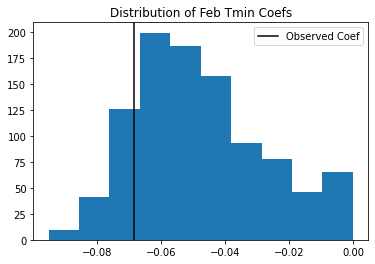

In [0]:
plt.hist(coefs.iloc[8])
plt.title('Distribution of Feb Tmin Coefs')
plt.axvline(observation.iloc[8].values, color = 'black', label = 'Observed Coef')
plt.legend()

In [0]:
results_dict = {}

for i, var_name in enumerate(var_names):

  #Positive observation
  if observation.iloc[i].values > 0:
    number_as_or_more_extreme = np.sum(coefs.iloc[i].values >= observation.iloc[i].values)
    results_dict[var_name] = [number_as_or_more_extreme]

  #Negative observation
  if observation.iloc[i].values < 0:
    number_as_or_more_extreme = np.sum(coefs.iloc[i].values <= observation.iloc[i].values)
    results_dict[var_name] = [number_as_or_more_extreme]

  elif observation.iloc[i].values == 0:
    continue

pd.DataFrame(results_dict)

**Method 2 Significance Testing: Look at the differences between observed and simulated coefficients. What proportion are more extreme than the observed coefficient?**

(array([226., 188., 135., 120.,  93.,  65.,  52.,  40.,  25.,  56.]),
 array([6.11272809e-05, 6.87976387e-03, 1.36984005e-02, 2.05170370e-02,
        2.73356736e-02, 3.41543102e-02, 4.09729468e-02, 4.77915834e-02,
        5.46102200e-02, 6.14288566e-02, 6.82474931e-02]),
 <a list of 10 Patch objects>)

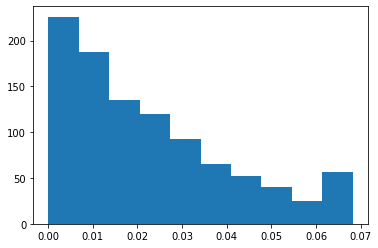

In [0]:
plt.hist(abs([df[df['index'] == 'February_tmin'].values[0][1]] * 1000 - coefs.iloc[8]))

In [0]:
abs_dif = abs([df[df['index'] == 'February_tmin'].values[0][1]] * 1000 - coefs.iloc[8]) 
    
np.sum(abs_dif.values >= abs(df[df['index'] == 'February_tmin']['observed_beta']).values)

27

1


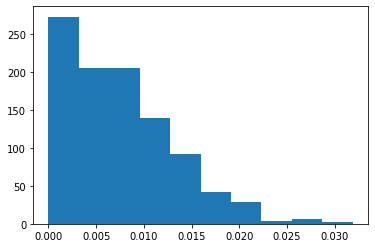

In [0]:
#Find differences between observed beta and simulated betas
df = observation.reset_index()
[df[df['index'] == 'March_ppt'].values[0][1]] * 1000

plt.hist(abs([df[df['index'] == 'March_ppt'].values[0][1]] * 1000 - coefs.iloc[12]))

abs_dif = abs([df[df['index'] == 'March_ppt'].values[0][1]] * 1000 - coefs.iloc[12]) 
    
print(np.sum(abs_dif.values >= abs(df[df['index'] == 'March_ppt']['observed_beta']).values))


In [0]:
results_dict = {}

for i, var_name in enumerate(var_names):

  #Non zero observation
  if observation.iloc[i].values != 0:
    df = observation.reset_index()

    abs_dif = abs([df[df['index'] == var_name].values[0][1]] * 1000 - coefs.iloc[i]) 
    
    num = np.sum(abs_dif.values >= abs(df[df['index'] == var_name]['observed_beta']).values)
    num = num/1000

    results_dict[var_name] = [num]

#Proportion of differences that are greater than the observed beta coef
pd.DataFrame(results_dict, index = [0]).T.sort_values(by = 0)

,0
February_ppt,0.000
March_ppt,0.001
February_tmin,0.027
May_vpdmax,0.224
July_ppt,0.273
January_tmax,0.276
October_ppt,0.312
August_tmin,0.393
January_ppt,0.423
July_tmean,0.497


**Method 3 Significance Testing: How many times was a coefficient NOT set to zero.**

In [0]:
#How many of the simulations produced nonzero coefficients
results_dict = {}

for i, var_name in enumerate(var_names):

  #How many times was the coefficient NOT zero
  results_dict[var_name] = np.sum(coefs.iloc[i].values != 0)

pd.DataFrame(results_dict, index = [0]).T.sort_values(by = 0, ascending = False)

,0
February_ppt,1000
March_ppt,999
February_tmin,973
May_vpdmax,776
July_ppt,734
...,...
September_tmean,14
April_tmax,12
April_tmean,3
March_tmean,1


**Method 4 of Significance Testing: Construct confidence intervals. Failed because the coefficients are biased**

In [0]:
#Our observed beta values
observation = pd.DataFrame(beta_hat_dict, index = [0]).T.rename(columns = {0:'observed_beta'})

#Simulated beta values
var_names = pd.Series(x_train.columns, name = 'variables')
coefs = pd.concat(boot_coefs, axis = 1)

#Observations and variable names concat
results = pd.concat([var_names, coefs], axis = 1)

#Find standard error of simulated betas
results['standard_error'] = results.std(axis = 1)

#Merge observed betas
results = results.merge(observation, left_on = 'variables', right_index = True)

**Find variables whose 95% confidence interval does not overlap with zero.**

In [0]:
results['contains_zero'] = results.apply(CI_contains_zero, axis = 1)
results[results['contains_zero'] == 'No'][['variables', 'standard_error', 'observed_beta', 'contains_zero']]

,variables,standard_error,observed_beta,contains_zero
6,February_ppt,0.009918,-0.037495,No
8,February_tmin,0.020494,-0.068247,No
10,February_vpdmax,0.003694,-0.023325,No
12,March_ppt,0.009373,-0.031880,No
28,May_vpdmax,0.011567,0.029694,No
36,July_ppt,0.006343,0.012758,No
39,July_tmean,0.010796,0.026417,No
48,September_ppt,0.002456,0.006767,No
65,November_vpdmin,0.005273,0.015722,No
69,December_tmean,0.005048,-0.013434,No


**In the original lasso model (not bootstrap) how much variance did we explain?**

In [0]:
np.corrcoef(y_train, lasso.predict(x_train))[0][1]**2

0.41267480275102525

#### Seasonality (with holdout set)


**Create train test split before bootstrapping. We will holdout a random 1/4 of our data.**

In [0]:
from sklearn.model_selection import train_test_split

predictors = almond_scaled.drop(columns = ['Year', 'No Tech Yield per Acre', 'Yield per Acre'])
target = almond_scaled['No Tech Yield per Acre']

x_train, x_test, y_train, y_test = train_test_split(predictors, target, random_state = 41, test_size = 0.25)

**Bootstrapping approach to determine historically significant variables in the testing set**

In [0]:
import random
from sklearn import linear_model
from sklearn.linear_model import LassoCV

#4 fold CV to determine penalty parameter
lassoCV = linear_model.LassoCV(n_alphas = 400, cv = 4, normalize = False, fit_intercept = True)
lassoCV.fit(x_train, y_train)

#Create lasso object
lasso = linear_model.Lasso(normalize = False, fit_intercept = True)

#Make final Lasso model with alpha value from CV
lasso.set_params(alpha=lassoCV.alpha_)
lasso.fit(x_train, y_train)

#Observed coefficients
beta_hat_dict = {}
for coef, feat in zip(lasso.coef_,x_train.columns):
    beta_hat_dict[feat] = coef

#Observed residuals
residuals = y_train - lasso.predict(x_train)

##Bootstrap!
#Number of residuals to resample
n = x_train.shape[0]

#Store coefficients
boot_coefs = []

#Store R2
boot_R2 = []

for i in range(1000):

  #Random sample of residuals. Convert from list -> series
  sample_residuals = np.random.choice(residuals, size = n, replace = True)
  sample_residuals = pd.Series(sample_residuals)

  #Add residuals to observed yields
  y_train_star = lasso.predict(x_train) + sample_residuals

  #Fit model
  lasso_boot = linear_model.Lasso(normalize = False, fit_intercept = True)
  lasso_boot.set_params(alpha = lassoCV.alpha_)
  lasso_boot.fit(x_train, y_train_star)

  #Collect coefficients
  df_coefs = pd.DataFrame.from_dict({'Coef':lasso_boot.coef_})
  unique_name = 'Coef_' + str(i)
  df_coefs = df_coefs.rename(columns = {'Coef':unique_name})
  boot_coefs.append(df_coefs)

  #Collect R2
  boot_R2.append(np.corrcoef(y_train_star, lasso_boot.predict(x_train))[0][1]**2)

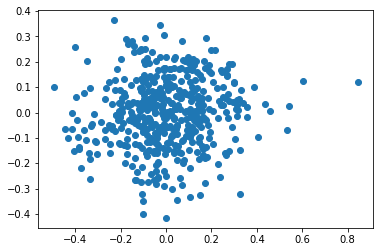

In [31]:
#Make a residual plot to see how the original model did.
#Ideally random noise centered along horizontal line at 0
plt.scatter(residuals, lasso.predict(x_train))

**Format results.**

In [32]:
#Our observed beta values
observation = pd.DataFrame(beta_hat_dict, index = [0]).T.rename(columns = {0:'observed_beta'})

#Simulated beta values
var_names = pd.Series(x_train.columns, name = 'variables')
coefs = pd.concat(boot_coefs, axis = 1)

#Observations and variable names concat
results = pd.concat([var_names, coefs], axis = 1)

#Merge observed betas
results = results.merge(observation, left_on = 'variables', right_index = True)

results.head()

,variables,Coef_0,Coef_1,Coef_2,Coef_3,Coef_4,Coef_5,Coef_6,Coef_7,Coef_8,Coef_9,Coef_10,Coef_11,Coef_12,Coef_13,Coef_14,Coef_15,Coef_16,Coef_17,Coef_18,Coef_19,Coef_20,Coef_21,Coef_22,Coef_23,Coef_24,Coef_25,Coef_26,Coef_27,Coef_28,Coef_29,Coef_30,Coef_31,Coef_32,Coef_33,Coef_34,Coef_35,Coef_36,Coef_37,Coef_38,...,Coef_961,Coef_962,Coef_963,Coef_964,Coef_965,Coef_966,Coef_967,Coef_968,Coef_969,Coef_970,Coef_971,Coef_972,Coef_973,Coef_974,Coef_975,Coef_976,Coef_977,Coef_978,Coef_979,Coef_980,Coef_981,Coef_982,Coef_983,Coef_984,Coef_985,Coef_986,Coef_987,Coef_988,Coef_989,Coef_990,Coef_991,Coef_992,Coef_993,Coef_994,Coef_995,Coef_996,Coef_997,Coef_998,Coef_999,observed_beta
0,January_ppt,-0.014982,-0.001033,-0.026445,-0.000000,-0.009912,-0.006951,-0.002231,-0.005136,-0.011178,-0.023009,-0.004635,0.000000,-0.007812,0.000000,-0.001718,-0.022990,-0.002306,-0.000000,-0.006734,-0.015435,-0.002022,-0.001417,-0.000903,-0.014786,-0.000000,-0.000000,0.000000,-0.012966,-0.006194,-0.000000,-0.012850,-0.016558,-0.020364,-0.025571,-0.010689,-0.000000,-0.021162,-0.023692,-0.016835,...,-0.008762,-0.022917,-0.000334,-0.016070,-0.018039,-0.015857,-0.020727,0.000000,-0.000000,-0.000770,-0.021993,-0.040451,0.000000,-0.014114,-0.014091,-0.022965,-0.005521,0.000000,-0.000901,-0.007674,-0.000000,-0.006056,-0.001882,-0.005112,-0.013639,-0.010974,-0.000000,-0.011722,-0.015645,-0.009566,-0.003765,-0.000000,-0.000000,-0.010344,-0.006290,-0.023423,-0.000000,-0.027050,-0.009691,-0.011288
1,January_tmax,-0.000000,-0.029612,-0.025173,-0.033286,-0.015518,-0.000000,-0.041146,-0.008599,-0.000000,-0.010354,-0.000000,-0.001435,-0.000000,-0.004450,-0.000000,-0.000000,-0.000000,-0.000000,-0.001770,-0.013360,-0.012109,-0.000000,-0.005903,-0.018317,-0.000000,-0.027461,-0.017142,-0.002646,-0.000000,-0.000000,-0.057299,-0.000000,-0.050538,-0.001430,-0.000000,-0.000000,-0.000000,-0.011531,-0.000000,...,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.019793,-0.000000,-0.000000,-0.000000,-0.000891,-0.015428,-0.000000,-0.000000,-0.020386,-0.000000,-0.016496,-0.020196,-0.006018,-0.018276,-0.000000,-0.000000,-0.000000,-0.014040,-0.000000,-0.049285,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.003665,-0.000000,-0.002263,-0.014632,-0.000000,-0.000000,-0.000000,-0.010236,-0.000000
2,January_tmin,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.008759,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.004022,-0.000000,-0.007815,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.002243,-0.000000,-0.000000,-0.025966,-0.000000,-0.000000,-0.000000,-0.039832,...,-0.000000,-0.005391,-0.005369,-0.000000,-0.012659,-0.012892,-0.000000,-0.000000,-0.011837,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000288,-0.000000,-0.004322,-0.000000,-0.000000,-0.000000,-0.000000,-0.021973,-0.000000,-0.000000,-0.000000,-0.000000,-0.021771,-0.000000,-0.000000,-0.020740,-0.000000,-0.000000,-0.000000,-0.000000
3,January_tmean,-0.028194,-0.007419,-0.020587,-0.000000,-0.012694,-0.033692,-0.000000,-0.037131,-0.043730,-0.023157,-0.042232,-0.003356,-0.041849,-0.011766,-0.044788,-0.007174,-0.000000,-0.018047,-0.022382,-0.021624,-0.000000,-0.019407,-0.034328,-0.000000,-0.015051,-0.002870,-0.000000,-0.032805,-0.022723,-0.024522,-0.004093,-0.036488,-0.001466,-0.000000,-0.000000,-0.035016,-0.046331,-0.007947,-0.007578,...,-0.025677,-0.060078,-0.025695,-0.025509,-0.000000,-0.027526,-0.000000,-0.047808,-0.000000,-0.023761,-0.036531,-0.000000,-0.045983,-0.050094,-0.015345,-0.034826,-0.000000,-0.009356,-0.022274,-0.012412,-0.000000,-0.042871,-0.013287,-0.019144,-0.033801,-0.006944,-0.013791,-0.019439,-0.022438,-0.056759,-0.042436,-0.026130,-0.016461,-0.014612,-0.039432,-0.016251,-0.012121,-0.017100,-0.000000,-0.031136
4,January_vpdmax,-0.018944,-0.000000,-0.005490,-0.003023,-0.000000,-0.000000,-0.000000,-0

**Significance using difference between observed beta and simulated betas**

In [35]:
results_dict = {}

for i, var_name in enumerate(var_names):

  #Non zero observation
  if observation.iloc[i].values != 0:
    df = observation.reset_index()

    abs_dif = abs([df[df['index'] == var_name].values[0][1]] * 1000 - coefs.iloc[i]) 
    
    num = np.sum(abs_dif.values >= abs(df[df['index'] == var_name]['observed_beta']).values)
    num = num/1000

    results_dict[var_name] = [num]

#Proportion of differences that are greater than the observed beta coef
pd.DataFrame(results_dict, index = [0]).T.sort_values(by = 0).head(10)

,0
February_ppt,0.000
March_ppt,0.038
July_ppt,0.041
October_ppt,0.138
February_tmin,0.153
May_vpdmax,0.207
January_tmean,0.224
November_vpdmin,0.264
December_tmean,0.302
February_vpdmin,0.350


**Significance based on number of times coefficient was set to zero.**

In [36]:
#How many of the simulations produced nonzero coefficients
results_dict = {}

for i, var_name in enumerate(var_names):

  #How many times was the coefficient NOT zero
  results_dict[var_name] = np.sum(coefs.iloc[i].values != 0)

pd.DataFrame(results_dict, index = [0]).T.sort_values(by = 0, ascending = False).head(10)

,0
February_ppt,1000
March_ppt,971
July_ppt,962
October_ppt,874
February_tmin,869
May_vpdmax,793
January_tmean,780
November_ppt,745
November_vpdmin,742
December_tmean,698


**Look at magnitude of coefficients.**

In [52]:
observed_coefs = pd.DataFrame(dict(zip(x_train.columns, lasso.coef_)), index = [0]).T.reset_index()
observed_coefs = observed_coefs.rename(columns = {'index':'var',
                                                  0:'coef'})
observed_coefs[observed_coefs['coef'] != 0].sort_values(by = 'coef')

#Look at absolute value
observed_coefs['abs_value'] = abs(observed_coefs['coef'])

observed_coefs.sort_values(by = 'abs_value', ascending = False)

,var,coef,abs_value
6,February_ppt,-0.047202,0.047202
28,May_vpdmax,0.040455,0.040455
8,February_tmin,-0.038048,0.038048
69,December_tmean,-0.032202,0.032202
3,January_tmean,-0.031136,0.031136
...,...,...,...
41,July_vpdmin,0.000000,0.000000
42,August_ppt,0.000000,0.000000
43,August_tmax,-0.000000,0.000000
18,April_ppt,0.000000,0.000000


In [54]:
#Order coefs by order in which months occur in a year and then alphabetically


observed_coefs['month'] = observed_coefs['var'].apply(word_to_num)
observed_coefs

,var,coef,abs_value,month
0,January_ppt,-0.011288,0.011288,1
1,January_tmax,-0.000000,0.000000,1
2,January_tmin,-0.000000,0.000000,1
3,January_tmean,-0.031136,0.031136,1
4,January_vpdmax,-0.012632,0.012632,1
...,...,...,...,...
67,December_tmax,-0.000000,0.000000,12
68,December_tmin,-0.000000,0.000000,12
69,December_tmean,-0.032202,0.032202,12
70,December_vpdmax,-0.018099,0.018099,12


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71]), <a list of 72 Text major ticklabel objects>)

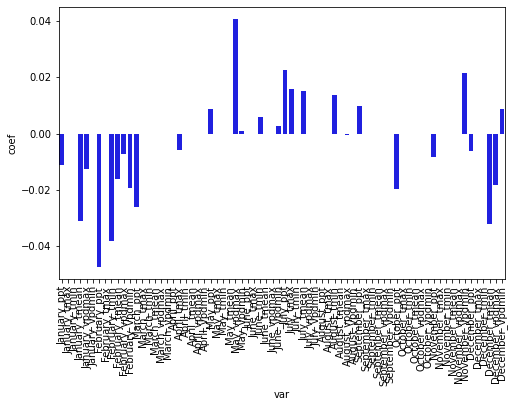

In [59]:
#In future you should color bars by season and start plot in August bc it occurs in year prior to harvest
fig, ax = plt.subplots(figsize = (8,5))
ax = sns.barplot(x = 'var', y = 'coef', data = observed_coefs, color = 'blue')
plt.xticks(rotation = 90)

**Check original model performance.**

In [37]:
print('Train: ', np.corrcoef(y_train, lasso.predict(x_train))[0][1]**2)
print('Test: ', np.corrcoef(y_test, lasso.predict(x_test))[0][1]**2)

Train:  0.419971026120359
Test:  0.4026740584182169


### County Level Differences

In [0]:
#Scale season based predictors but keep counties in
from sklearn.preprocessing import StandardScaler

#Create scaler
scaler = StandardScaler()

#Save a copy of our residuals. We don't want these scaled
almond_no_scale = df_seasons[['County','No Tech Yield per Acre', 'Yield per Acre']].reset_index(drop = True)

#Fit and transform the data (now an array). Remove columns we don't want scaled (no tech and tech yields)
scaled_array = scaler.fit_transform(df_seasons.drop(columns = ['County','No Tech Yield per Acre', 'Yield per Acre']))

#Convert array back to df
scaled_df = pd.DataFrame(scaled_array, columns = df_seasons.drop(columns = ['County','No Tech Yield per Acre', 'Yield per Acre']).columns)

#Add the counties and yield per acre back in
almond_scaled = scaled_df.join(almond_no_scale)

In [0]:
import random 

#Make list of training and testing counties
counties = list(almond_scaled['County'].unique())

#Drop year and yield per acre (predicting no tech yield per acre)
df = almond_scaled.drop(columns = ['Yield per Acre', 'Year'])

#Collect results
R2_train = []
R2_test = []

for i in range(100):
  test_counties = random.sample(counties, 4)
  train_counties = []

  for c in counties:
    if c not in test_counties:
      train_counties.append(c)
    else:
      continue

  #Split the data into train and test
  train = df[df['County'].isin(train_counties)]
  test = df[df['County'].isin(test_counties)]

  #Drop the county column
  train = train.drop(columns = ['County'])
  test = test.drop(columns = ['County'])

  #Split train/test into predictors and targets
  x_train = train.drop(columns = ['No Tech Yield per Acre']).values
  y_train = train['No Tech Yield per Acre'].values

  x_test = test.drop(columns = ['No Tech Yield per Acre']).values
  y_test = test['No Tech Yield per Acre'].values

  #LassoCV to determine alpha based on training data
  lassoCV = linear_model.LassoCV(eps=0.0001, n_alphas=400, max_iter=200000, cv= 4, normalize=False, fit_intercept = True)
  lassoCV.fit(x_train, y_train)

  #Create lasso object
  lasso = linear_model.Lasso(max_iter = 200000, normalize = False, fit_intercept = True)

  #Make final Lasso model with alpha value from CV
  lasso.set_params(alpha=lassoCV.alpha_)
  lasso.fit(x_train, y_train)

  #Results
  R2_train.append(np.corrcoef(y_train, lasso.predict(x_train))[0][1]**2)
  R2_test.append(np.corrcoef(y_test, lasso.predict(x_test))[0][1]**2)

  if i%10 == 0:
    print(i)

In [0]:
plt.hist(R2_train, color = 'Red')
plt.hist(R2_test, color = 'Blue')

In [0]:
print(np.mean(R2_train), np.std(R2_train))
print(np.mean(R2_test), np.std(R2_test))

#Model Accounts for Alternate Bearing

## Account for alternate bearing

We will only consider counties with a full set of observations. We are also assuming that all counties are affected by time the sameway. That is, that they all have have the same alternate bearing effect.

In [0]:
#Only select counties that have a complete set of 38 observations
df = df_almonds.groupby('County').count().reset_index()
counties = df.loc[df['Year'] == 38, 'County'].values

#Filtered to complete counties
df_almonds_c = df_almonds[df_almonds['County'].isin(counties)]

#Sort by year and county SO THE OBSERVATIONS STILL LINE UP
df_almonds_c = df_almonds_c.sort_values(by = ['Year', 'County'])

#Add two columns that have shifted tech adjusted yields
df_almonds_c['Last Year No Tech Yield'] = df_almonds_c['No Tech Yield per Acre'].shift(periods = 16)
df_almonds_c['Two Year Ago No Tech Yield'] = df_almonds_c['No Tech Yield per Acre'].shift(periods = 32)

#Add two columns that have shifted RAW yields
df_almonds_c['Last Year Yield'] = df_almonds_c['Yield per Acre'].shift(periods = 16)
df_almonds_c['Two Year Ago Yield'] = df_almonds_c['Yield per Acre'].shift(periods = 32)

#Drop rows with na
df_almonds_c = df_almonds_c[df_almonds_c['Year'] > 1981]

**Remove effect of alternate bearing**

In [0]:
target = df_almonds_c['No Tech Yield per Acre'].values
predictor = df_almonds_c[['Last Year No Tech Yield', 'Two Year Ago No Tech Yield']].values

model = linear_model.LinearRegression()
model.fit(predictor, target)

alternate_trend = model.predict(predictor)

#Look at R2
print(np.corrcoef(alternate_trend, df_almonds_c['No Tech Yield per Acre'])[0][1]**2)

#Residuals
df_almonds_c['No Tech No Alt Yield per Acre'] = df_almonds_c['No Tech Yield per Acre'] - alternate_trend

In [0]:
df_almonds_c

## Seasonality

In [0]:
df_seasons = df_almonds_c.drop(columns = ['Commodity Code', 'Crop Name', 'County Code', 'Harvested Acres',
                                        'Price per Unit', 'Unit', 'Total Value', 'Production', 'No Tech Yield per Acre', 'Last Year No Tech Yield',
                                        'Two Year Ago No Tech Yield', 'Last Year Yield', 'Two Year Ago Yield'])

shifted_dfs = []
for county in df_seasons['County'].unique():

  #Filter to county
  df = df_seasons[df_seasons['County'] == county]

  for var in df_seasons.columns:
    if any(x in var for x in ['August', 'September', 'October', 'November', 'December']):
      df[var] = df[var].shift(periods = 1)

    else:
      continue

  #Drop rows with nas
  df = df.dropna(axis = 0, how = 'any')
  shifted_dfs.append(df)

df_seasons = pd.concat(shifted_dfs)

## Scale Predictors

In [0]:
#Scale season based df
df_almonds_scale_prep = df_seasons.drop(columns = ['County'])


#Create scaler
scaler = StandardScaler()

#Save a copy of our residuals. We don't want these scaled
almond_no_scale = df_almonds_scale_prep[['No Tech No Alt Yield per Acre', 'Yield per Acre']].reset_index(drop = True)

#Fit and transform the data (now an array). Remove columns we don't want scaled (no tech and tech yields)
scaled_array = scaler.fit_transform(df_almonds_scale_prep.drop(columns = ['No Tech No Alt Yield per Acre', 'Yield per Acre']))

#Convert array back to df
scaled_df = pd.DataFrame(scaled_array, columns = df_almonds_scale_prep.drop(columns = ['No Tech No Alt Yield per Acre', 'Yield per Acre']).columns)

#Add the counties and yield per acre back in
almond_scaled = scaled_df.join(almond_no_scale)

## Bootstrapping Lasso

In [0]:
#Use entire dataset
x_train = almond_scaled.drop(columns = ['Year', 'No Tech No Alt Yield per Acre', 'Yield per Acre'])
y_train = almond_scaled['No Tech No Alt Yield per Acre']

#4 fold CV to determine penalty parameter
lassoCV = linear_model.LassoCV(n_alphas = 400, cv = 4, normalize = False, fit_intercept = True)
lassoCV.fit(x_train, y_train)

#Create lasso object
lasso = linear_model.Lasso(normalize = False, fit_intercept = True)

#Make final Lasso model with alpha value from CV
lasso.set_params(alpha=lassoCV.alpha_)
lasso.fit(x_train, y_train)

#Observed coefficients
beta_hat_dict = {}
for coef, feat in zip(lasso.coef_,x_train.columns):
    beta_hat_dict[feat] = coef

#Observed residuals
residuals = y_train - lasso.predict(x_train)

##Bootstrap!
#Number of residuals to resample
n = x_train.shape[0]

#Store coefficients
boot_coefs = []
for i in range(1000):

  #Random sample of residuals. Convert from list -> series
  sample_residuals = np.random.choice(residuals, size = n, replace = True)
  sample_residuals = pd.Series(sample_residuals)

  #Add residuals to observed yields
  y_train_star = y_train + sample_residuals

  #Fit model
  lasso_boot = linear_model.Lasso(normalize = False, fit_intercept = True)
  lasso_boot.set_params(alpha = lassoCV.alpha_)
  lasso_boot.fit(x_train, y_train_star)

  #Collect coefficients
  df_coefs = pd.DataFrame.from_dict({'Coef':lasso_boot.coef_})
  unique_name = 'Coef_' + str(i)
  df_coefs = df_coefs.rename(columns = {'Coef':unique_name})
  boot_coefs.append(df_coefs)

In [0]:
#Our observed beta values
observation = pd.DataFrame(beta_hat_dict, index = [0]).T.rename(columns = {0:'observed_beta'})

#Simulated beta values
var_names = pd.Series(x_train.columns, name = 'variables')
coefs = pd.concat(boot_coefs, axis = 1)

#Observations and variable names concat
results = pd.concat([var_names, coefs], axis = 1)

#Find standard error of simulated betas
results['standard_error'] = results.std(axis = 1)

#Merge observed betas
results = results.merge(observation, left_on = 'variables', right_index = True)

In [0]:
results['contains_zero'] = results.apply(CI_contains_zero, axis = 1)
results[results['contains_zero'] == 'No']

In [0]:
np.corrcoef(y_train, lasso.predict(x_train))[0][1]**2

#Wine Grapes

## Data Processing

In [0]:
df_yield = pd.read_csv('/content/county_weather_yield.csv', index_col = 0)

#Wine grapes only
df_grapes = df_yield[df_yield['Crop Name'] == 'GRAPES WINE']

df_grapes = df_grapes[~df_grapes['Yield per Acre'].isnull()]

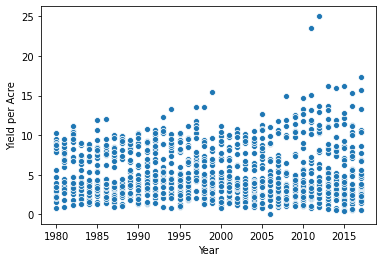

In [65]:
sns.scatterplot(x = 'Year', y = 'Yield per Acre', data = df_grapes)

**Remove technology trend**

In [67]:
#Predict yields using only years
target = df_grapes['Yield per Acre'].values
predictor = df_grapes['Year'].values
predictor_formatted = np.reshape(predictor, (len(predictor), 1))

#Fit model on entire dataset
model = linear_model.LinearRegression()
model.fit(predictor_formatted, target)

#Predict entire dataset from years
tech_trend = model.predict(predictor_formatted)

#Now consider residuals only
df_grapes['No Tech Yield per Acre'] = df_grapes['Yield per Acre'] - tech_trend

#We do not expect the fit to be very good because tech does not have a strong influence on grapes
np.corrcoef(target, model.predict(predictor_formatted))[0][1]**2

8.09311532909706e-05

**Introduce seasonality. Assume all grapes harvested August 1st.**

In [111]:
df_seasons = df_grapes.drop(columns = ['Commodity Code', 'Crop Name', 'County Code', 'Harvested Acres',
                                        'Price per Unit', 'Unit', 'Total Value', 'Production'])

#We can only implement seasonality if we have a 2 continuous years yields. Handle discontinous counties separate.

df_seasons = df_seasons[~df_seasons['County'].isin(['Placer', 'Contra Costa'])]

shifted_dfs = []
for county in df_seasons['County'].unique():

  #Filter to county
  df = df_seasons[df_seasons['County'] == county]

  for var in df_seasons.columns:
    if any(x in var for x in ['August', 'September', 'October', 'November', 'December']):
      df[var] = df[var].shift(periods = 1)
      
    else:
      continue

  #Drop rows with nas
  df = df.dropna(axis = 0, how = 'any')
  shifted_dfs.append(df)

df_seasonality = pd.concat(shifted_dfs)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [0]:
##Discontinous counties
df_grapes_placer1 = df_seasons[(df_seasons['County'] == 'Placer') & (df_seasons['Year'] < 2001)]
df_grapes_placer2 = df_seasons[(df_seasons['County'] == 'Placer') & (df_seasons['Year'] < 2000)]

df_grapes_CC1 = df_seasons[(df_seasons['County'] == 'Contra Costa') & (df_seasons['Year'] < 1988)]
df_grapes_CC2 = df_seasons[(df_seasons['County'] == 'Contra Costa') & (df_seasons['Year'] > 1987)]

shifted_dfs2 = []
for df_county in [df_grapes_placer1, df_grapes_placer2, df_grapes_CC1, df_grapes_CC2]:

  df = df_county

  for var in df.columns:
    if any(x in var for x in ['August', 'September', 'October', 'November', 'December']):
      df[var] = df[var].shift(periods = 1)
      
    else:
      continue

  #Drop rows with nas
  df = df.dropna(axis = 0, how = 'any')
  shifted_dfs2.append(df)


#Discon. counties together
df_seasonality2 = pd.concat(shifted_dfs2)

#All counties together
df_seasons = pd.concat([df_seasonality, df_seasonality2])

**Scale predictors**

In [0]:
#Scale season based df
from sklearn.preprocessing import StandardScaler
df_grapes_scale_prep = df_seasons.drop(columns = ['County'])

#Create scaler
scaler = StandardScaler()

#Save a copy of our residuals. We don't want these scaled
grapes_no_scale = df_grapes_scale_prep[['No Tech Yield per Acre', 'Yield per Acre']].reset_index(drop = True)

#Fit and transform the data (now an array). Remove columns we don't want scaled (no tech and tech yields)
scaled_array = scaler.fit_transform(df_grapes_scale_prep.drop(columns = ['No Tech Yield per Acre', 'Yield per Acre']))

#Convert array back to df
scaled_df = pd.DataFrame(scaled_array, columns = df_grapes_scale_prep.drop(columns = ['No Tech Yield per Acre', 'Yield per Acre']).columns)

#Add the counties and yield per acre back in
grapes_scaled = scaled_df.join(grapes_no_scale)

## Seasonality with holdout

In [0]:
from sklearn.model_selection import train_test_split

predictors = grapes_scaled.drop(columns = ['Year', 'No Tech Yield per Acre', 'Yield per Acre'])
target = grapes_scaled['No Tech Yield per Acre']

x_train, x_test, y_train, y_test = train_test_split(predictors, target, random_state = 41, test_size = 0.25)

In [0]:
import random
from sklearn import linear_model
from sklearn.linear_model import LassoCV

#4 fold CV to determine penalty parameter
lassoCV = linear_model.LassoCV(n_alphas = 400, cv = 4, normalize = False, fit_intercept = True)
lassoCV.fit(x_train, y_train)

#Create lasso object
lasso = linear_model.Lasso(normalize = False, fit_intercept = True)

#Make final Lasso model with alpha value from CV
lasso.set_params(alpha=lassoCV.alpha_)
lasso.fit(x_train, y_train)

#Observed coefficients
beta_hat_dict = {}
for coef, feat in zip(lasso.coef_,x_train.columns):
    beta_hat_dict[feat] = coef

#Observed residuals
residuals = y_train - lasso.predict(x_train)

##Bootstrap!
#Number of residuals to resample
n = x_train.shape[0]

#Store coefficients
boot_coefs = []

#Store R2
boot_R2 = []

for i in range(1000):

  #Random sample of residuals. Convert from list -> series
  sample_residuals = np.random.choice(residuals, size = n, replace = True)
  sample_residuals = pd.Series(sample_residuals)

  #Add residuals to observed yields
  y_train_star = lasso.predict(x_train) + sample_residuals

  #Fit model
  lasso_boot = linear_model.Lasso(normalize = False, fit_intercept = True)
  lasso_boot.set_params(alpha = lassoCV.alpha_)
  lasso_boot.fit(x_train, y_train_star)

  #Collect coefficients
  df_coefs = pd.DataFrame.from_dict({'Coef':lasso_boot.coef_})
  unique_name = 'Coef_' + str(i)
  df_coefs = df_coefs.rename(columns = {'Coef':unique_name})
  boot_coefs.append(df_coefs)

  #Collect R2
  boot_R2.append(np.corrcoef(y_train_star, lasso_boot.predict(x_train))[0][1]**2)

In [127]:
lasso.alpha

0.0027284110233584346

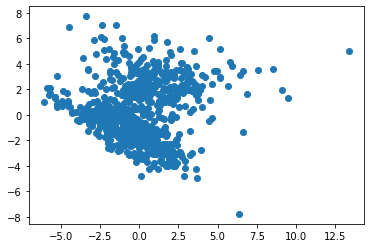

In [128]:
#Make a residual plot to see how the original model did.
#Ideally random noise centered along horizontal line at 0
plt.scatter(residuals, lasso.predict(x_train))

In [129]:
#Our observed beta values
observation = pd.DataFrame(beta_hat_dict, index = [0]).T.rename(columns = {0:'observed_beta'})

#Simulated beta values
var_names = pd.Series(x_train.columns, name = 'variables')
coefs = pd.concat(boot_coefs, axis = 1)

#Observations and variable names concat
results = pd.concat([var_names, coefs], axis = 1)

#Merge observed betas
results = results.merge(observation, left_on = 'variables', right_index = True)

results.head()

,variables,Coef_0,Coef_1,Coef_2,Coef_3,Coef_4,Coef_5,Coef_6,Coef_7,Coef_8,Coef_9,Coef_10,Coef_11,Coef_12,Coef_13,Coef_14,Coef_15,Coef_16,Coef_17,Coef_18,Coef_19,Coef_20,Coef_21,Coef_22,Coef_23,Coef_24,Coef_25,Coef_26,Coef_27,Coef_28,Coef_29,Coef_30,Coef_31,Coef_32,Coef_33,Coef_34,Coef_35,Coef_36,Coef_37,Coef_38,...,Coef_961,Coef_962,Coef_963,Coef_964,Coef_965,Coef_966,Coef_967,Coef_968,Coef_969,Coef_970,Coef_971,Coef_972,Coef_973,Coef_974,Coef_975,Coef_976,Coef_977,Coef_978,Coef_979,Coef_980,Coef_981,Coef_982,Coef_983,Coef_984,Coef_985,Coef_986,Coef_987,Coef_988,Coef_989,Coef_990,Coef_991,Coef_992,Coef_993,Coef_994,Coef_995,Coef_996,Coef_997,Coef_998,Coef_999,observed_beta
0,January_ppt,0.045335,0.012147,0.272671,0.108811,0.113722,-0.208314,0.243499,0.239736,0.049216,0.241812,0.098153,0.035695,0.112887,0.184473,0.249091,-0.000000,-0.004378,0.197728,-0.324464,0.270816,0.000000,0.043519,0.077840,0.076474,0.042180,-0.080258,0.126453,-0.032957,0.038404,0.217773,0.205929,0.032521,0.078438,-0.168746,0.259998,0.152661,0.104496,0.000000,0.087163,...,0.294129,0.251572,-0.016438,0.364803,0.013050,0.211649,-0.137107,0.044624,0.064607,0.234564,-0.084205,0.187610,0.027906,0.289635,0.099279,0.062484,-0.044514,-0.231230,0.301261,-0.592163,-0.094570,0.236039,-0.053940,0.050968,0.063746,0.391149,0.138931,-0.067787,-0.027297,0.176214,0.216319,0.085232,-0.010641,0.151620,0.134200,0.004803,0.216154,-0.150728,0.204129,0.107816
1,January_tmax,1.825416,1.308556,2.793150,2.129915,1.516781,1.116463,1.832235,1.940572,1.002459,1.170889,2.018321,1.373844,1.769422,1.450679,1.632895,1.237835,1.732130,2.073231,1.139140,2.028127,2.469248,1.583896,1.434036,3.010528,1.417541,1.527243,2.280426,1.244927,1.632837,2.202049,1.347974,2.011223,1.747806,1.435912,2.523713,1.116398,2.332315,1.400344,1.378580,...,1.771806,2.806611,1.323635,3.092371,3.229373,1.598747,1.749700,1.744616,1.706091,1.902480,1.302704,1.367165,2.581882,2.654261,1.349407,1.179119,1.894190,1.505749,2.775078,2.002690,1.891564,1.986006,1.222404,1.837096,1.419304,2.036795,2.591832,1.401242,1.073287,2.033740,2.087714,2.257469,2.563970,1.988738,1.953958,1.329213,1.177736,1.351161,1.848749,2.115942
2,January_tmin,-0.879610,-0.703633,-2.044436,-1.779978,-1.131866,-0.947650,-0.908321,-1.338504,-0.766245,-0.876015,-0.911255,-1.033189,-1.237987,-1.182751,-1.053065,-0.696830,-1.142312,-1.528625,-0.791789,-1.421052,-1.558885,-1.089331,-1.228538,-1.311113,-1.051517,-1.052122,-1.555125,-0.876896,-1.047535,-1.249589,-1.179137,-1.631228,-1.125596,-0.944709,-1.588566,-0.928936,-1.639888,-1.122068,-1.333460,...,-1.133475,-1.541600,-0.831868,-2.077974,-1.955395,-1.536402,-0.946356,-1.202133,-0.900713,-1.476606,-0.930063,-0.954010,-1.621589,-1.626985,-1.191920,-0.756779,-0.966610,-1.117518,-1.631052,-1.304854,-1.439742,-1.218016,-0.825819,-1.109980,-1.380172,-1.282793,-1.496275,-1.035230,-0.893851,-1.348400,-1.348192,-1.439276,-1.175392,-1.559081,-1.668401,-0.836701,-0.997202,-1.277940,-1.115698,-1.355617
3,January_tmean,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,January_vpdmax,-2.241615,-1.591158,-3.152526,-2.714371,-1.705559,-1.989934,-2.293775,-2.019066,-1.520370,-1.822371,-2.640690,-2.089980,-2.479893,-1.463424,-2.424430,-1.832668,-2.836863,-2.253156,-2.342235,-2.093004,-2.881209,-1.990663,-1.987863,-3.299778,-2.332411,-2.478692,-2.586729,-2.178957,-2.

In [131]:
results_dict = {}

for i, var_name in enumerate(var_names):

  #Non zero observation
  if observation.iloc[i].values != 0:
    df = observation.reset_index()

    abs_dif = abs([df[df['index'] == var_name].values[0][1]] * 1000 - coefs.iloc[i]) 
    
    num = np.sum(abs_dif.values >= abs(df[df['index'] == var_name]['observed_beta']).values)
    num = num/1000

    results_dict[var_name] = [num]

#Proportion of differences that are greater than the observed beta coef
pd.DataFrame(results_dict, index = [0]).T.sort_values(by = 0).head(20)

,0
May_vpdmax,0.000
July_tmin,0.000
August_ppt,0.000
October_ppt,0.000
July_vpdmin,0.000
January_tmax,0.000
January_vpdmax,0.000
January_tmin,0.001
June_tmin,0.001
February_vpdmax,0.005


In [132]:
observed_coefs = pd.DataFrame(dict(zip(x_train.columns, lasso.coef_)), index = [0]).T.reset_index()
observed_coefs = observed_coefs.rename(columns = {'index':'var',
                                                  0:'coef'})
observed_coefs[observed_coefs['coef'] != 0].sort_values(by = 'coef')

#Look at absolute value
observed_coefs['abs_value'] = abs(observed_coefs['coef'])

observed_coefs.sort_values(by = 'abs_value', ascending = False)

,var,coef,abs_value
4,January_vpdmax,-2.728817,2.728817
28,May_vpdmax,2.444704,2.444704
1,January_tmax,2.115942,2.115942
38,July_tmin,1.914099,1.914099
41,July_vpdmin,-1.804538,1.804538
25,May_tmax,-1.699221,1.699221
32,June_tmin,1.522007,1.522007
40,July_vpdmax,1.396947,1.396947
2,January_tmin,-1.355617,1.355617
34,June_vpdmax,-1.191179,1.191179


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71]), <a list of 72 Text major ticklabel objects>)

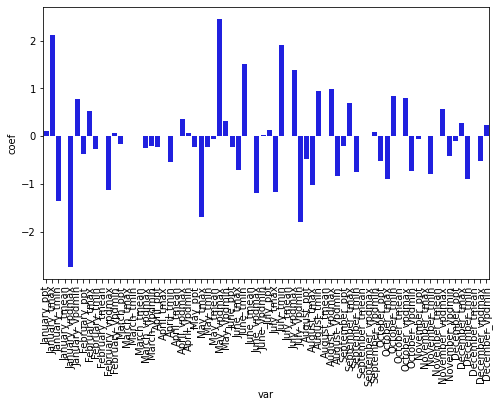

In [133]:
#In future you should color bars by season and start plot in August bc it occurs in year prior to harvest
fig, ax = plt.subplots(figsize = (8,5))
ax = sns.barplot(x = 'var', y = 'coef', data = observed_coefs, color = 'blue')
plt.xticks(rotation = 90)

In [134]:
print('Train: ', np.corrcoef(y_train, lasso.predict(x_train))[0][1]**2)
print('Test: ', np.corrcoef(y_test, lasso.predict(x_test))[0][1]**2)

Train:  0.538461877777922
Test:  0.4889143232525821
